<a href="https://colab.research.google.com/github/yidanchen0302/Time-Series-Forecasting-of-PM2.5-concentration-in-Beijing/blob/main/PM2_5_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [ ]:

!pip install pmdarima
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import signal
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
import os
from google.colab import files
import math
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, LSTM

 
uploaded = files.upload()
df = pd.read_csv('airpollution.csv',parse_dates=['date'])
print(df.head())
print(df.columns)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


Saving airpollution.csv to airpollution.csv
        date CityName  AQI   PM25   PM10   SO2    CO    NO     O3  temp
0 2013-12-01      北京市  100   73.3   97.0  37.1  1.73  56.0   37.7  -3.6
1 2014-01-01      北京市  125   93.9  122.8  51.4  1.95  65.0   36.6  -3.7
2 2014-02-01      北京市  184  148.4  155.4  56.4  2.17  68.6   41.5  -0.6
3 2014-03-01      北京市  130   93.6  137.8  33.7  1.39  62.3   82.9   5.1
4 2014-04-01      北京市  127   88.6  144.7  16.3  0.93  57.4  129.0  14.0
Index(['date', 'CityName', 'AQI', 'PM25', 'PM10', 'SO2', 'CO', 'NO', 'O3',
       'temp'],
      dtype='object')


#**plot time series for 7 variables**

Text(0.5, 1.0, 'Air Pollution Concentration')

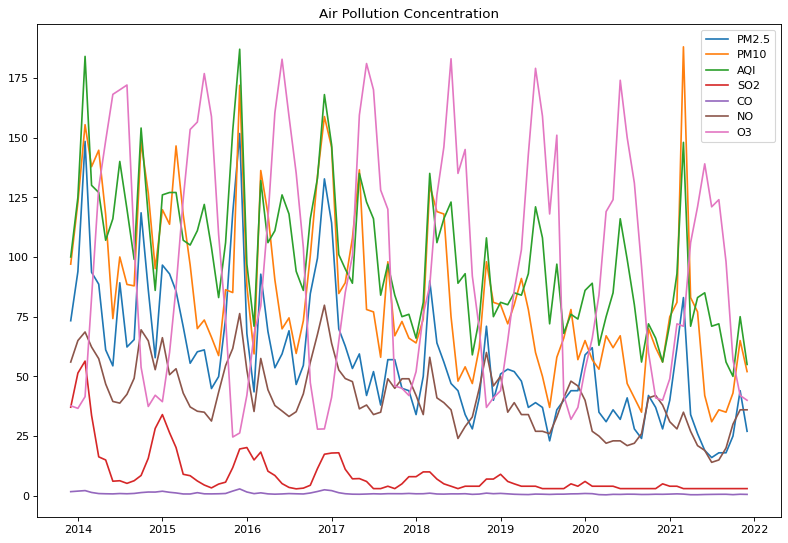

In [ ]:
def plot_df(df,x,y,title="",xlabel='Date',ylabel='Concentration',dpi=100):
    plt.figure(figsize=(16,5),dpi=dpi)
    plt.plot(x,y,color='tab:red')
    plt.gca().set(title=title,xlabel=xlabel,ylabel=ylabel)
    plt.show()

fig, ax = plt.subplots(figsize=(12,8),dpi=80)

ax.plot(df.index, df.PM25,label='PM2.5')
ax.plot(df.index, df.PM10,label='PM10')
ax.plot(df.index, df.AQI,label='AQI')
ax.plot(df.index, df.SO2,label='SO2')
ax.plot(df.index, df.CO,label='CO')
ax.plot(df.index, df.NO,label='NO')
ax.plot(df.index, df.O3,label='O3')

ax.legend(loc='best')
ax.set_title('Air Pollution Concentration')

In [ ]:
df.head(n=5)

,CityName,AQI,PM25,PM10,SO2,CO,NO,O3,temp
date,,,,,,,,,
2013-12-01,北京市,100,73.3,97.0,37.1,1.73,56.0,37.7,-3.6
2014-01-01,北京市,125,93.9,122.8,51.4,1.95,65.0,36.6,-3.7
2014-02-01,北京市,184,148.4,155.4,56.4,2.17,68.6,41.5,-0.6
2014-03-01,北京市,130,93.6,137.8,33.7,1.39,62.3,82.9,5.1
2014-04-01,北京市,127,88.6,144.7,16.3,0.93,57.4,129.0,14.0


# **Focus on PM2.5**

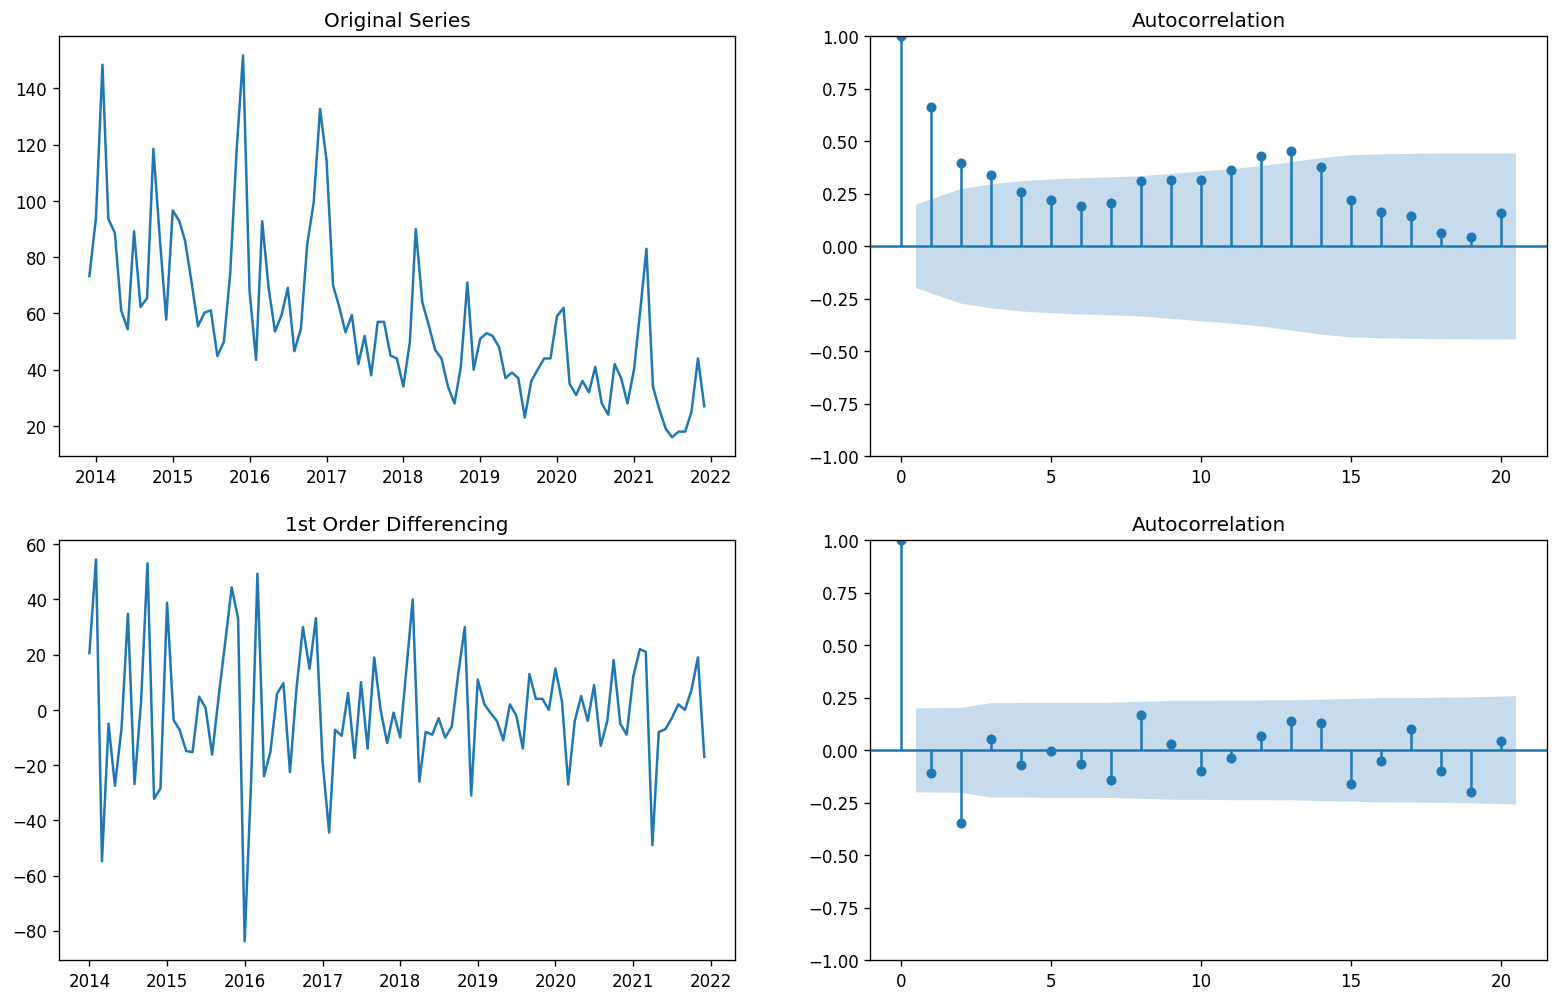

In [ ]:
#Focus on PM25
plt.rcParams.update({'figure.figsize':(16,10),'figure.dpi':120})

#Original Series

fig,axes = plt.subplots(2,2,sharex=False)
axes[0,0].plot(df.index,df.PM25);axes[0,0].set_title('Original Series')
plot_acf(df.PM25, ax=axes[0,1])

#1st Differencing
axes[1,0].plot(df.index,df.PM25.diff()); axes[1,0].set_title('1st Order Differencing')
plot_acf(df.PM25.diff().dropna(),ax=axes[1,1])

plt.show()

# **Test for stationarity**

ADF Statistic: -0.541932
p-value: 0.883571
ADF Statistic: -5.845863
p-value: 0.000000
ADF Statistic: -7.532246
p-value: 0.000000


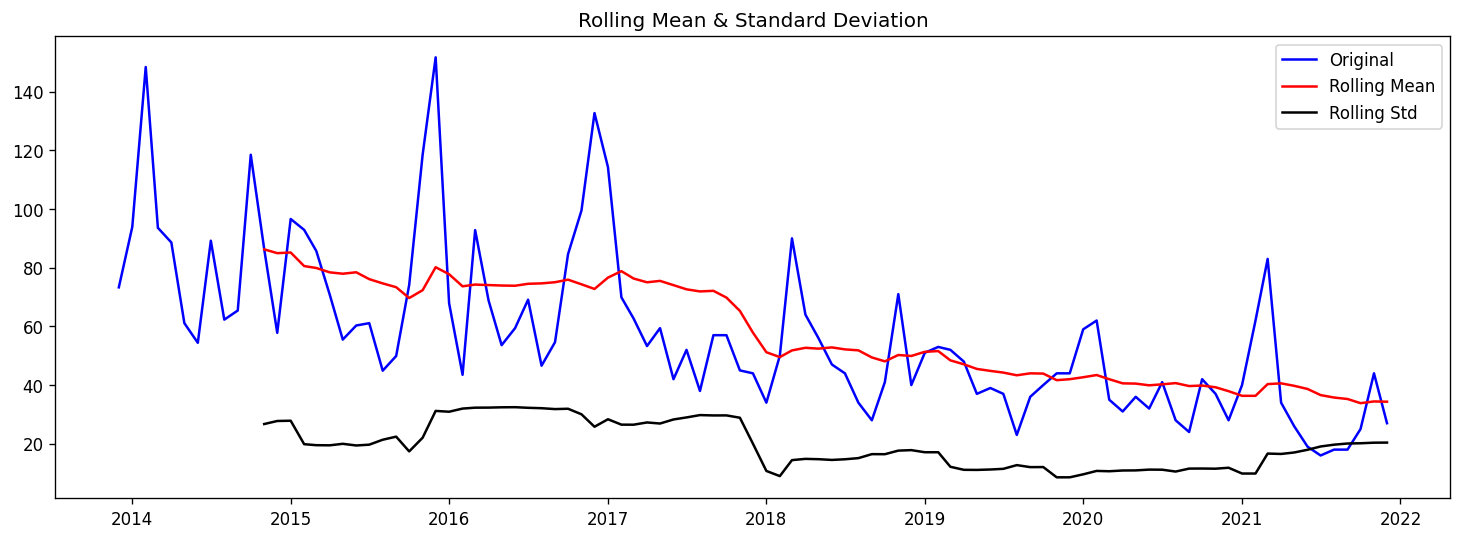

Results of Dickey-Fuller Test:
Test Statistic                 -0.541932
p-value                         0.883571
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


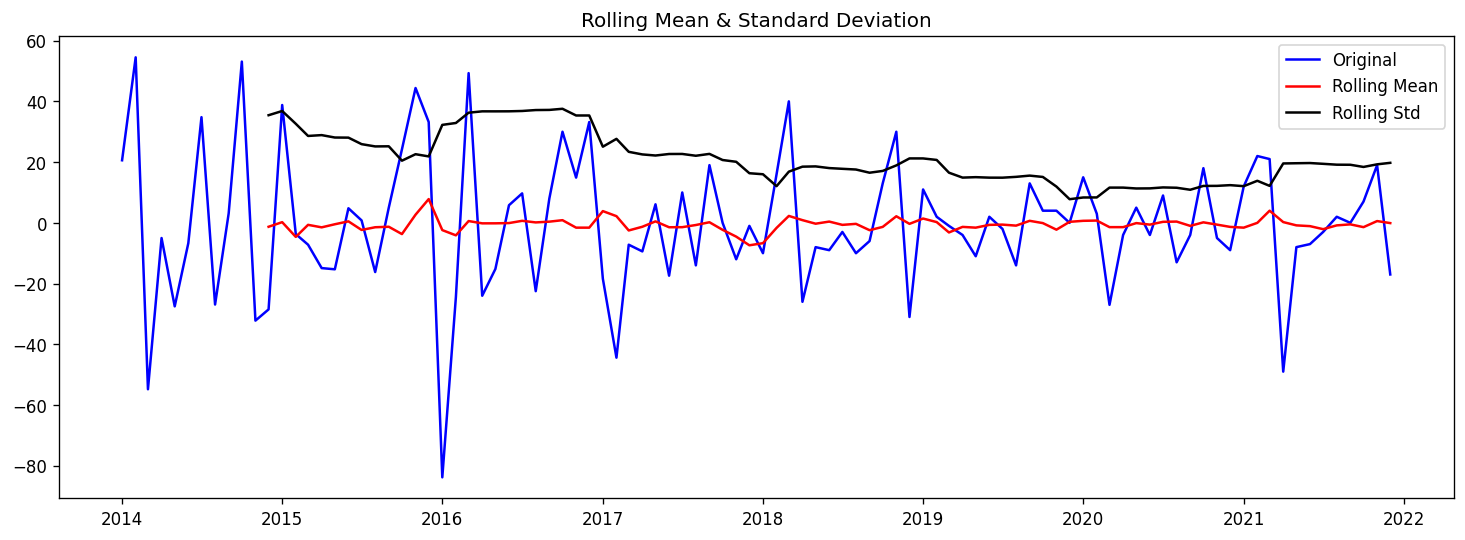

Results of Dickey-Fuller Test:
Test Statistic                -5.845863e+00
p-value                        3.685051e-07
#Lags Used                     1.200000e+01
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [ ]:
#ADF test for the origin data
result = adfuller(df.PM25.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#ADF test for the 1st diff data
result = adfuller(df.PM25.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#ADF test for the 2nd diff
result = adfuller(df.PM25.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#plot the rolling mean and rolling standard deviation
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df.PM25)    
test_stationarity(df.PM25.diff().dropna())   


# **Plot ACF and PACF for the 1st diff**

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


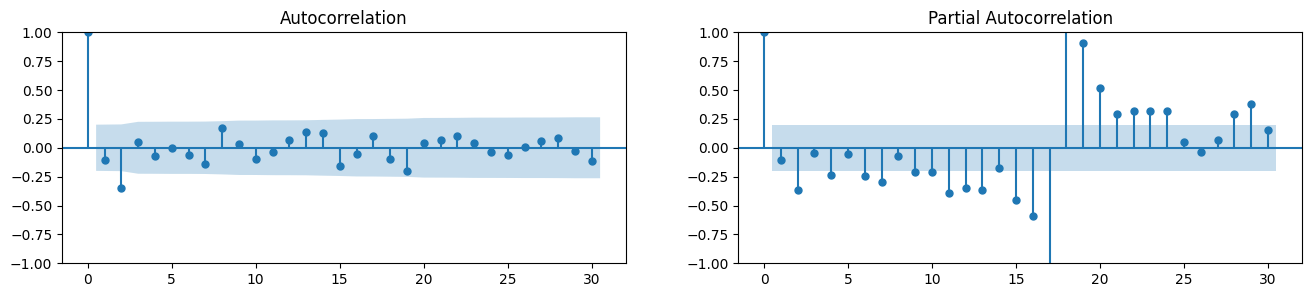

In [ ]:
fig,axes = plt.subplots(1,2,figsize =(16,3),dpi=100)
plot_acf(df.PM25.diff().dropna(),lags=30,ax=axes[0])
plot_pacf(df.PM25.diff().dropna(),lags=30,ax=axes[1])
plt.show()

# **Run loop over 1st diff different lag lengths**

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dat

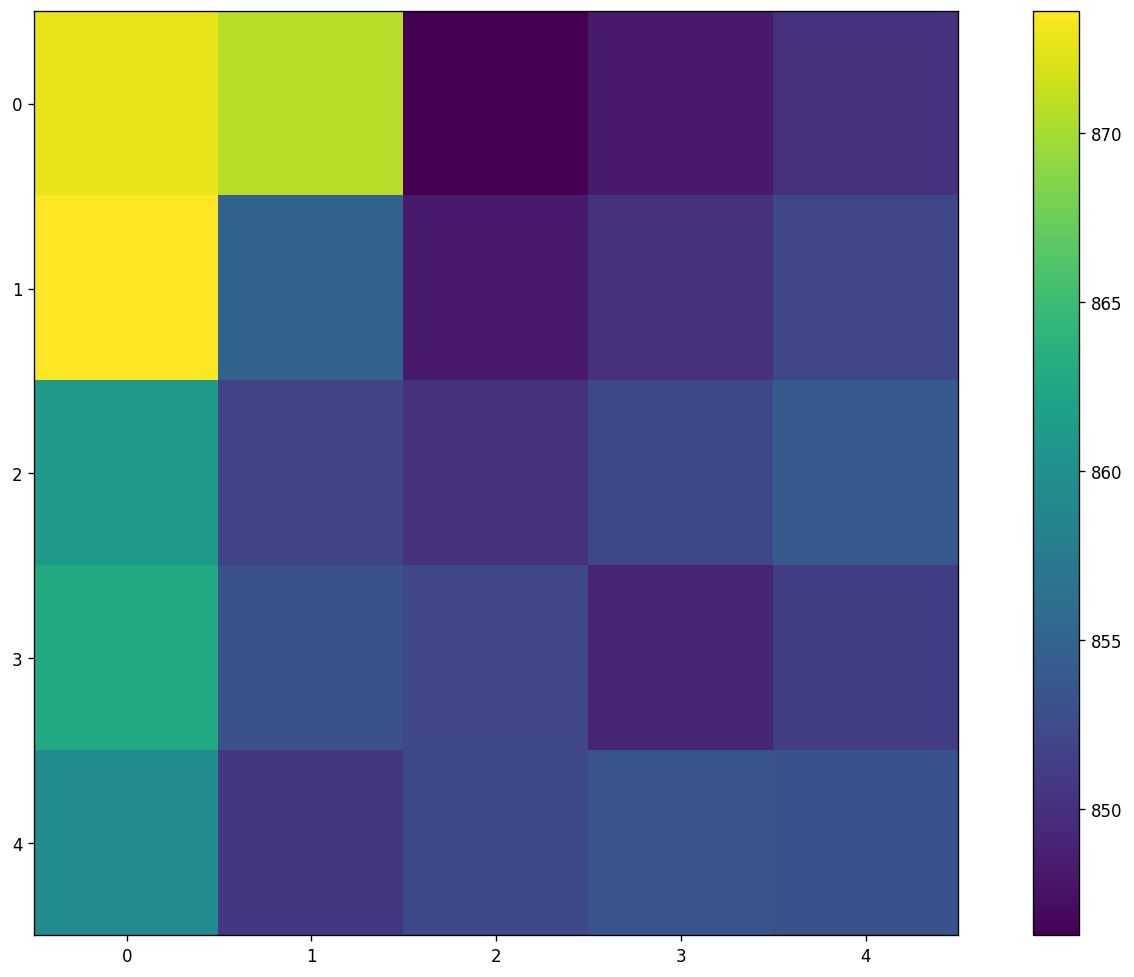

In [ ]:
# run loop over 1st diff different lag lengths
results_aic = np.zeros((5,5))
for ar_lag in range(0,5):
    for ma_lag in range(0,5):
        model = ARIMA(df['PM25'], order=(ar_lag,1,ma_lag))
        model_fit = model.fit()
        results_aic[ar_lag,ma_lag] = model_fit.aic
 
# determine optimum lag lengths for 1 diff
plt.imshow(results_aic)
plt.colorbar()
plt.show()
np.min(results_aic)
a = np.where(results_aic == np.min(results_aic))






# **APPLY ARIMA FOR 1ST DIFF**

In [ ]:
model = ARIMA(df.PM25,order=(a[0][0],1,a[1][0]))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   PM25   No. Observations:                   97
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -420.130
Date:                Mon, 24 Apr 2023   AIC                            846.259
Time:                        04:54:01   BIC                            853.952
Sample:                    12-01-2013   HQIC                           849.369
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2802      0.102     -2.751      0.006      -0.480      -0.081
ma.L2         -0.5557      0.087     -6.368      0.000      -0.727      -0.385
sigma2       365.7047     54.742      6.681      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Plot the residual error**

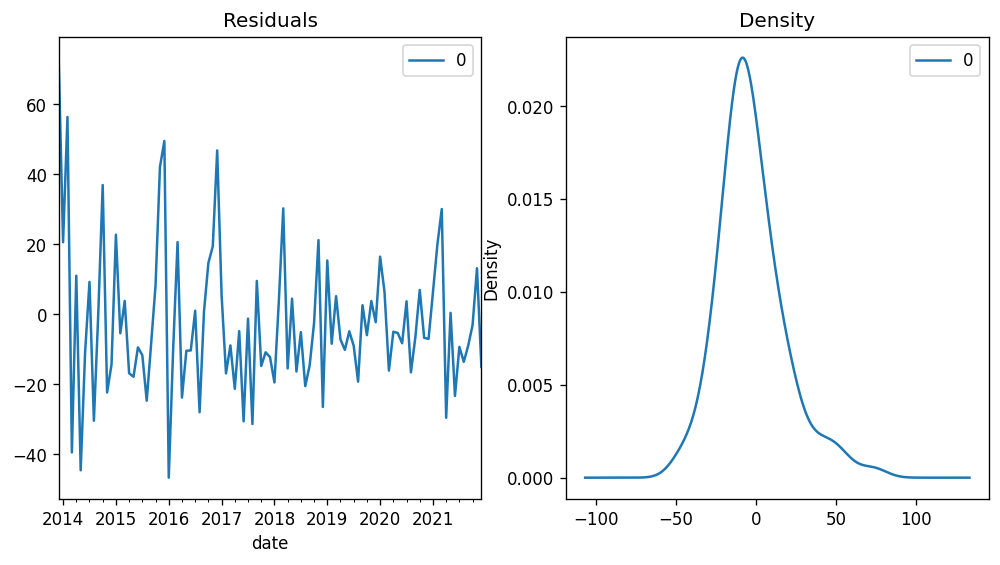

In [ ]:
plt.rcParams.update({'figure.figsize':(10,5),'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title = 'Density',ax=ax[1])
plt.show()

**Plot the actual vs. fitted data**

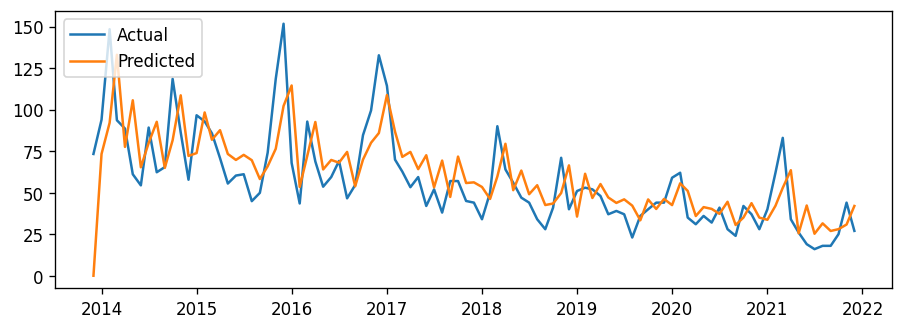

MSE:  432.10456186286575


In [ ]:
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})
df['predict'] = model_fit.predict()  
plt.plot(df.PM25,label='Actual')
plt.plot(df.predict, label='Predicted')
plt.legend(loc='upper left')
plt.show()
mse = np.mean((df.PM25 - df.predict)**2)
print("MSE: ", mse)

# **Seasonality**

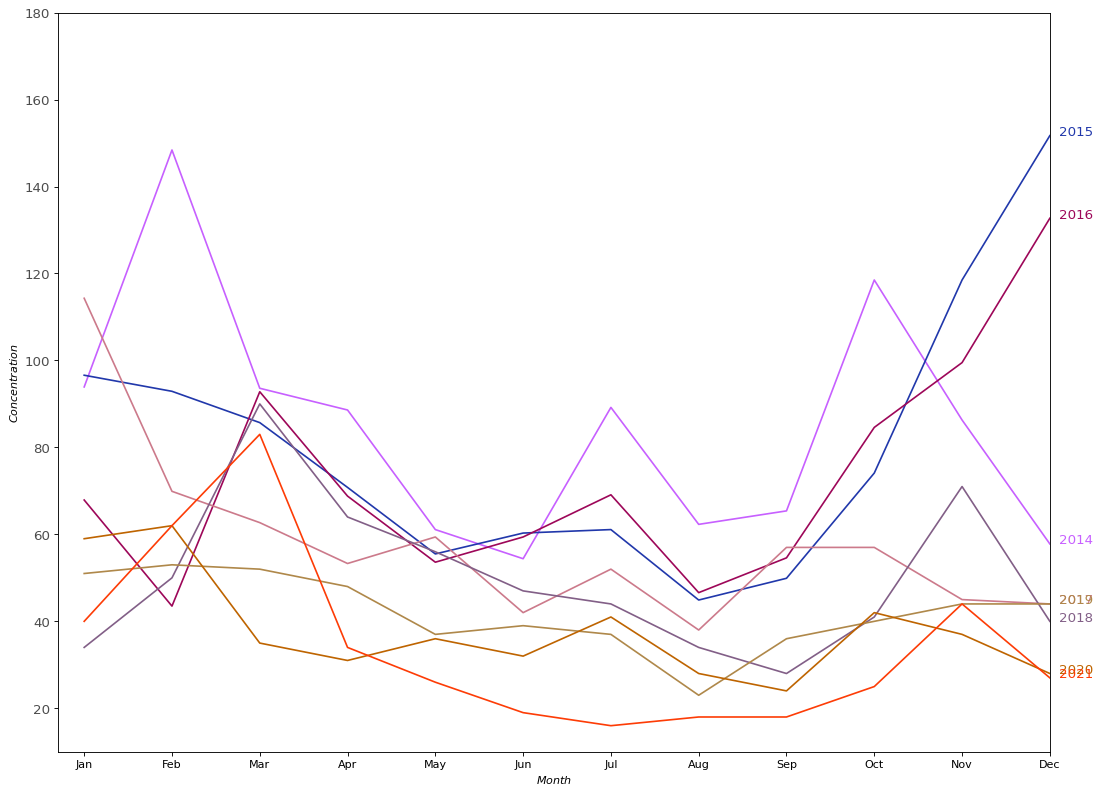

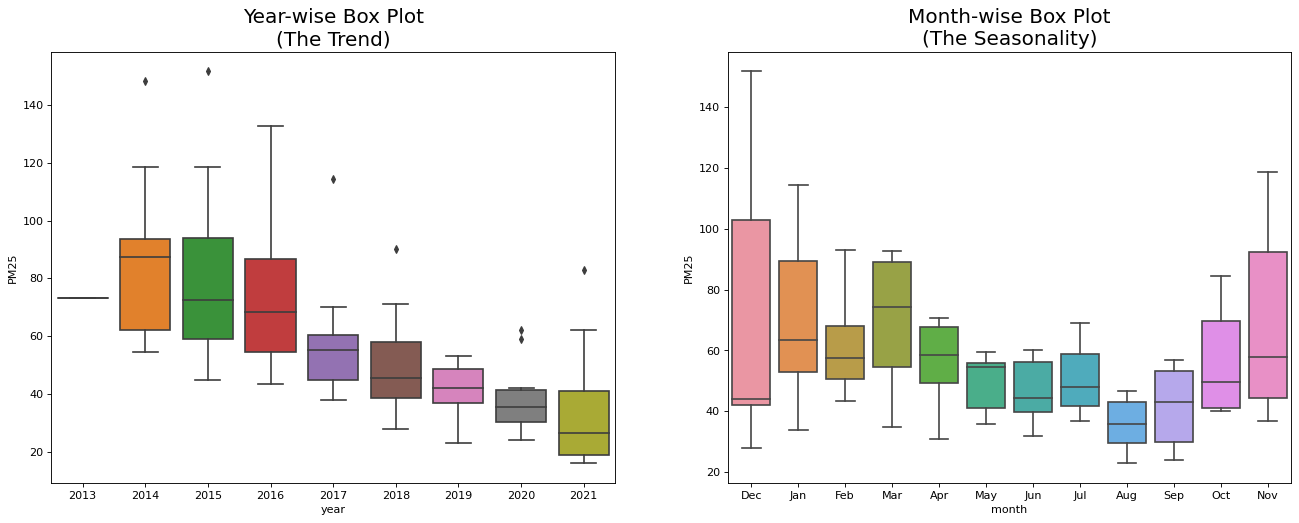

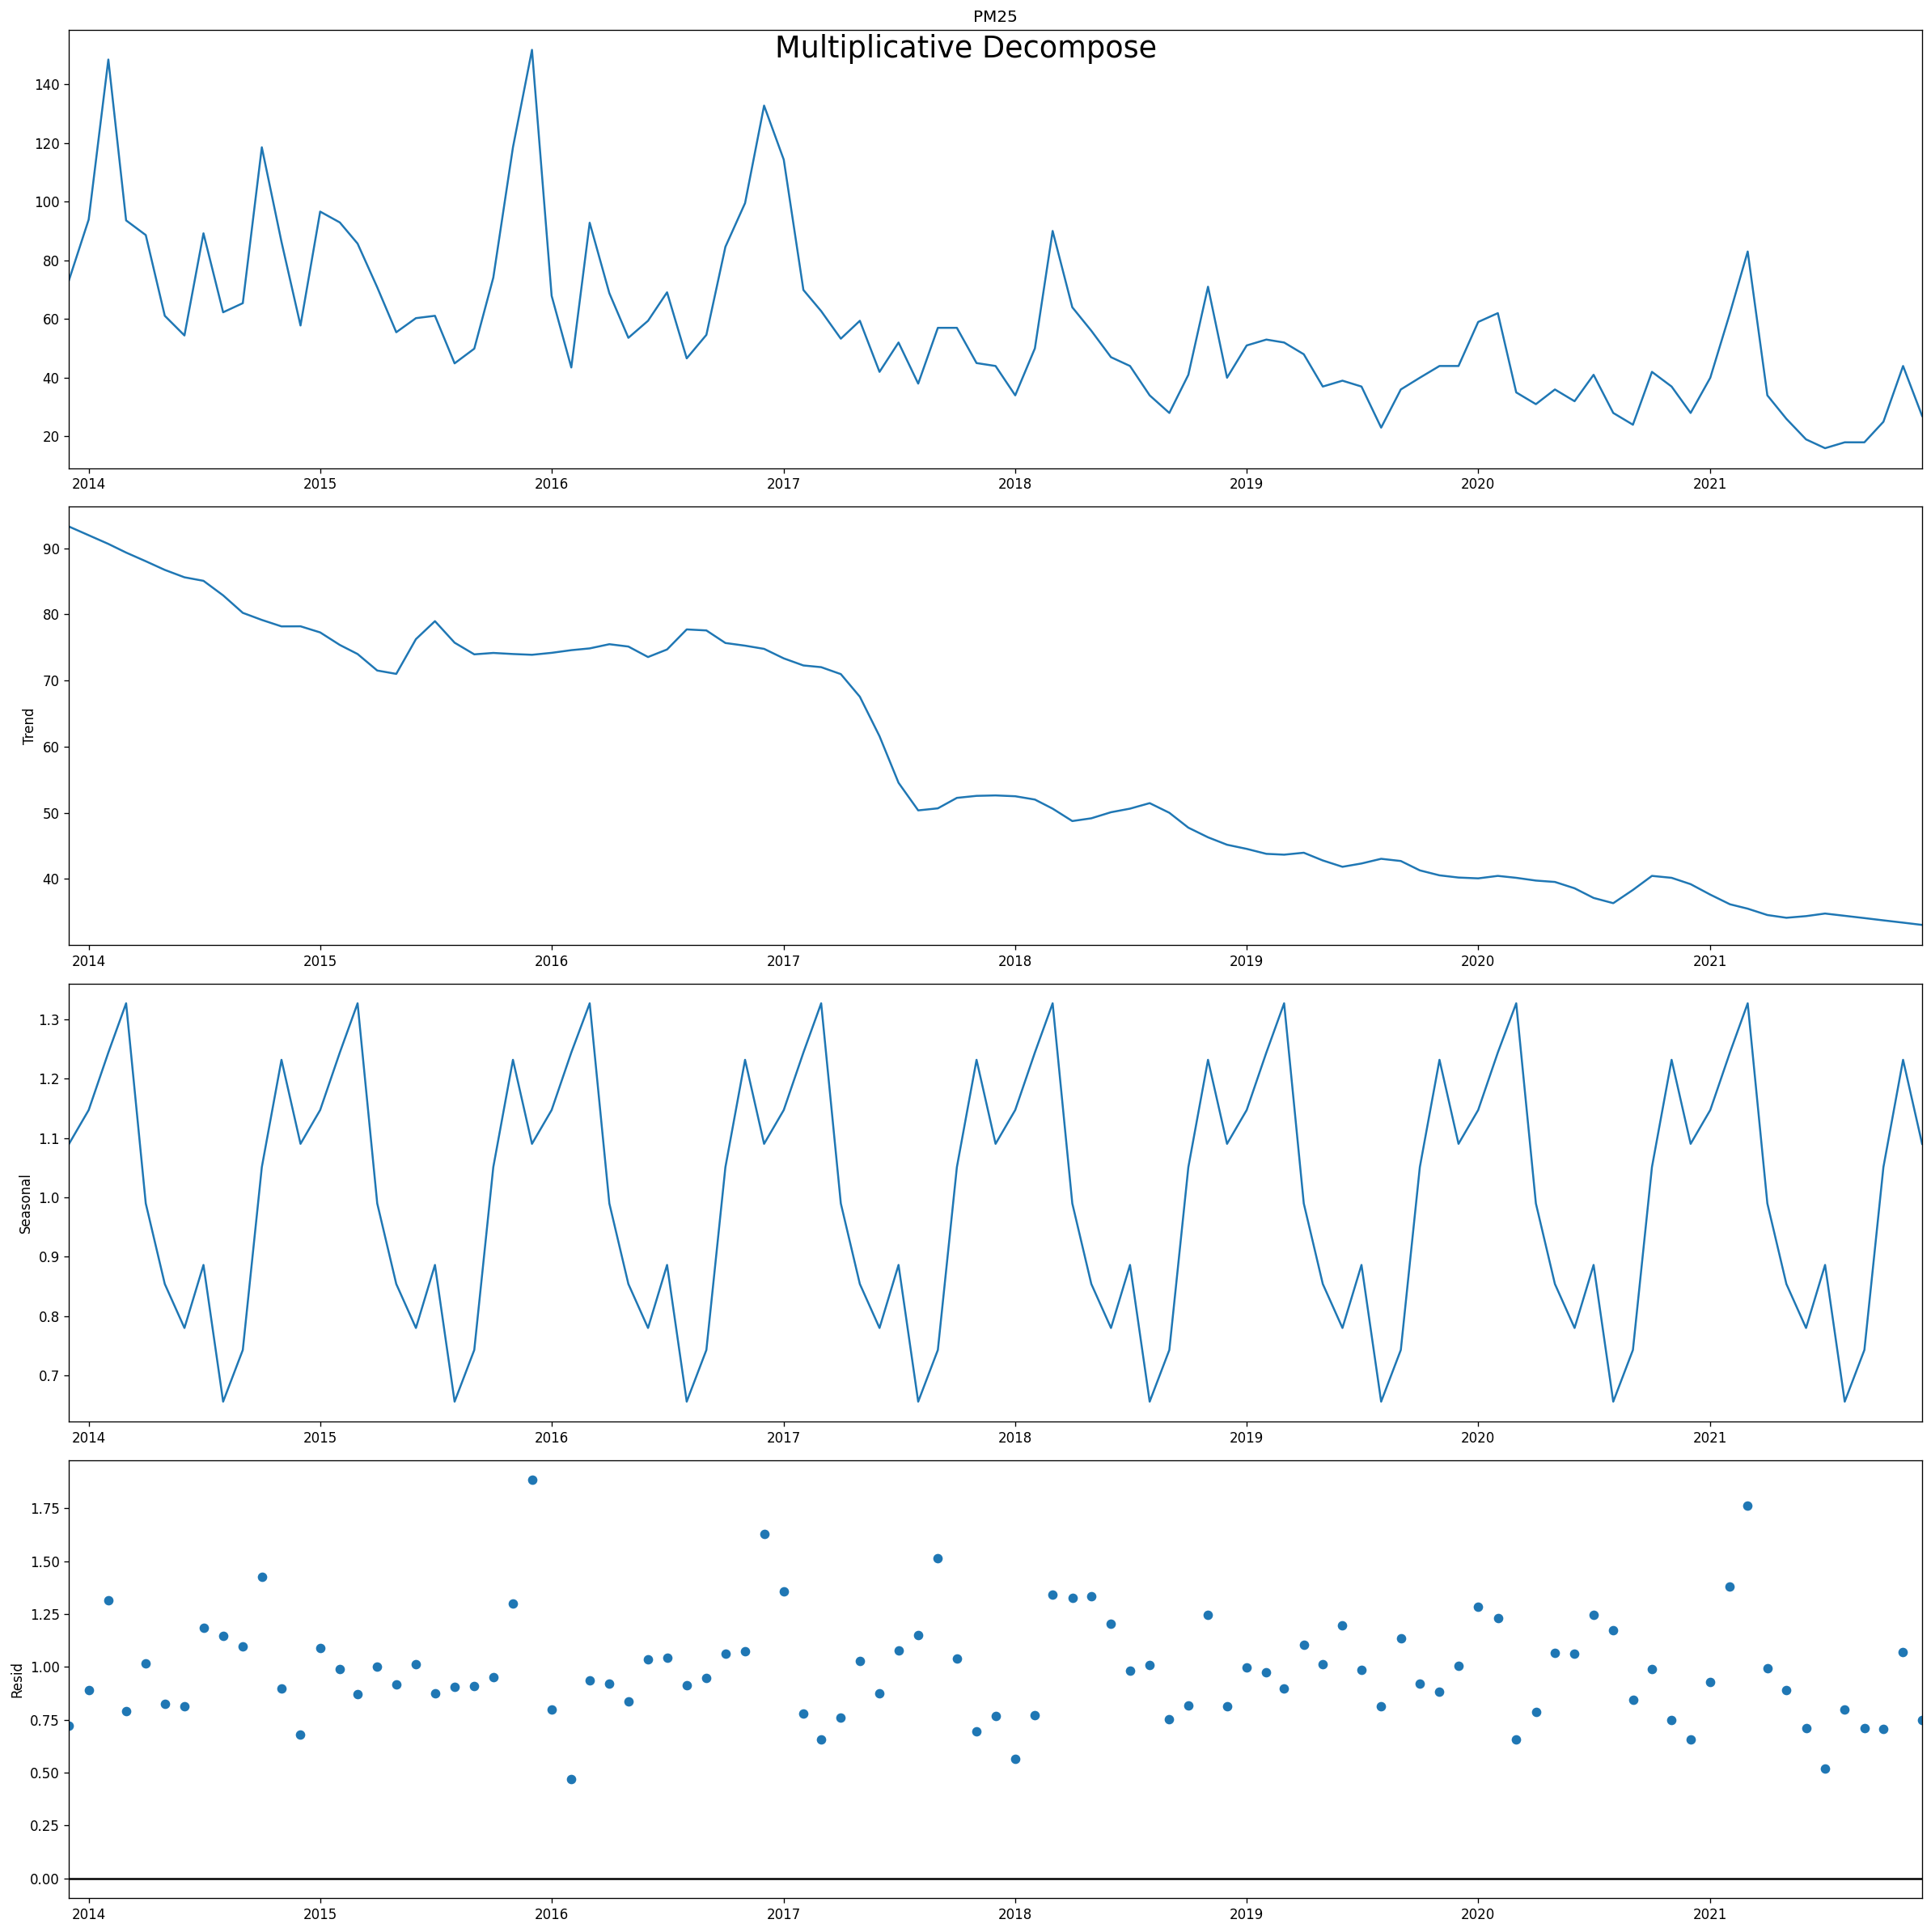

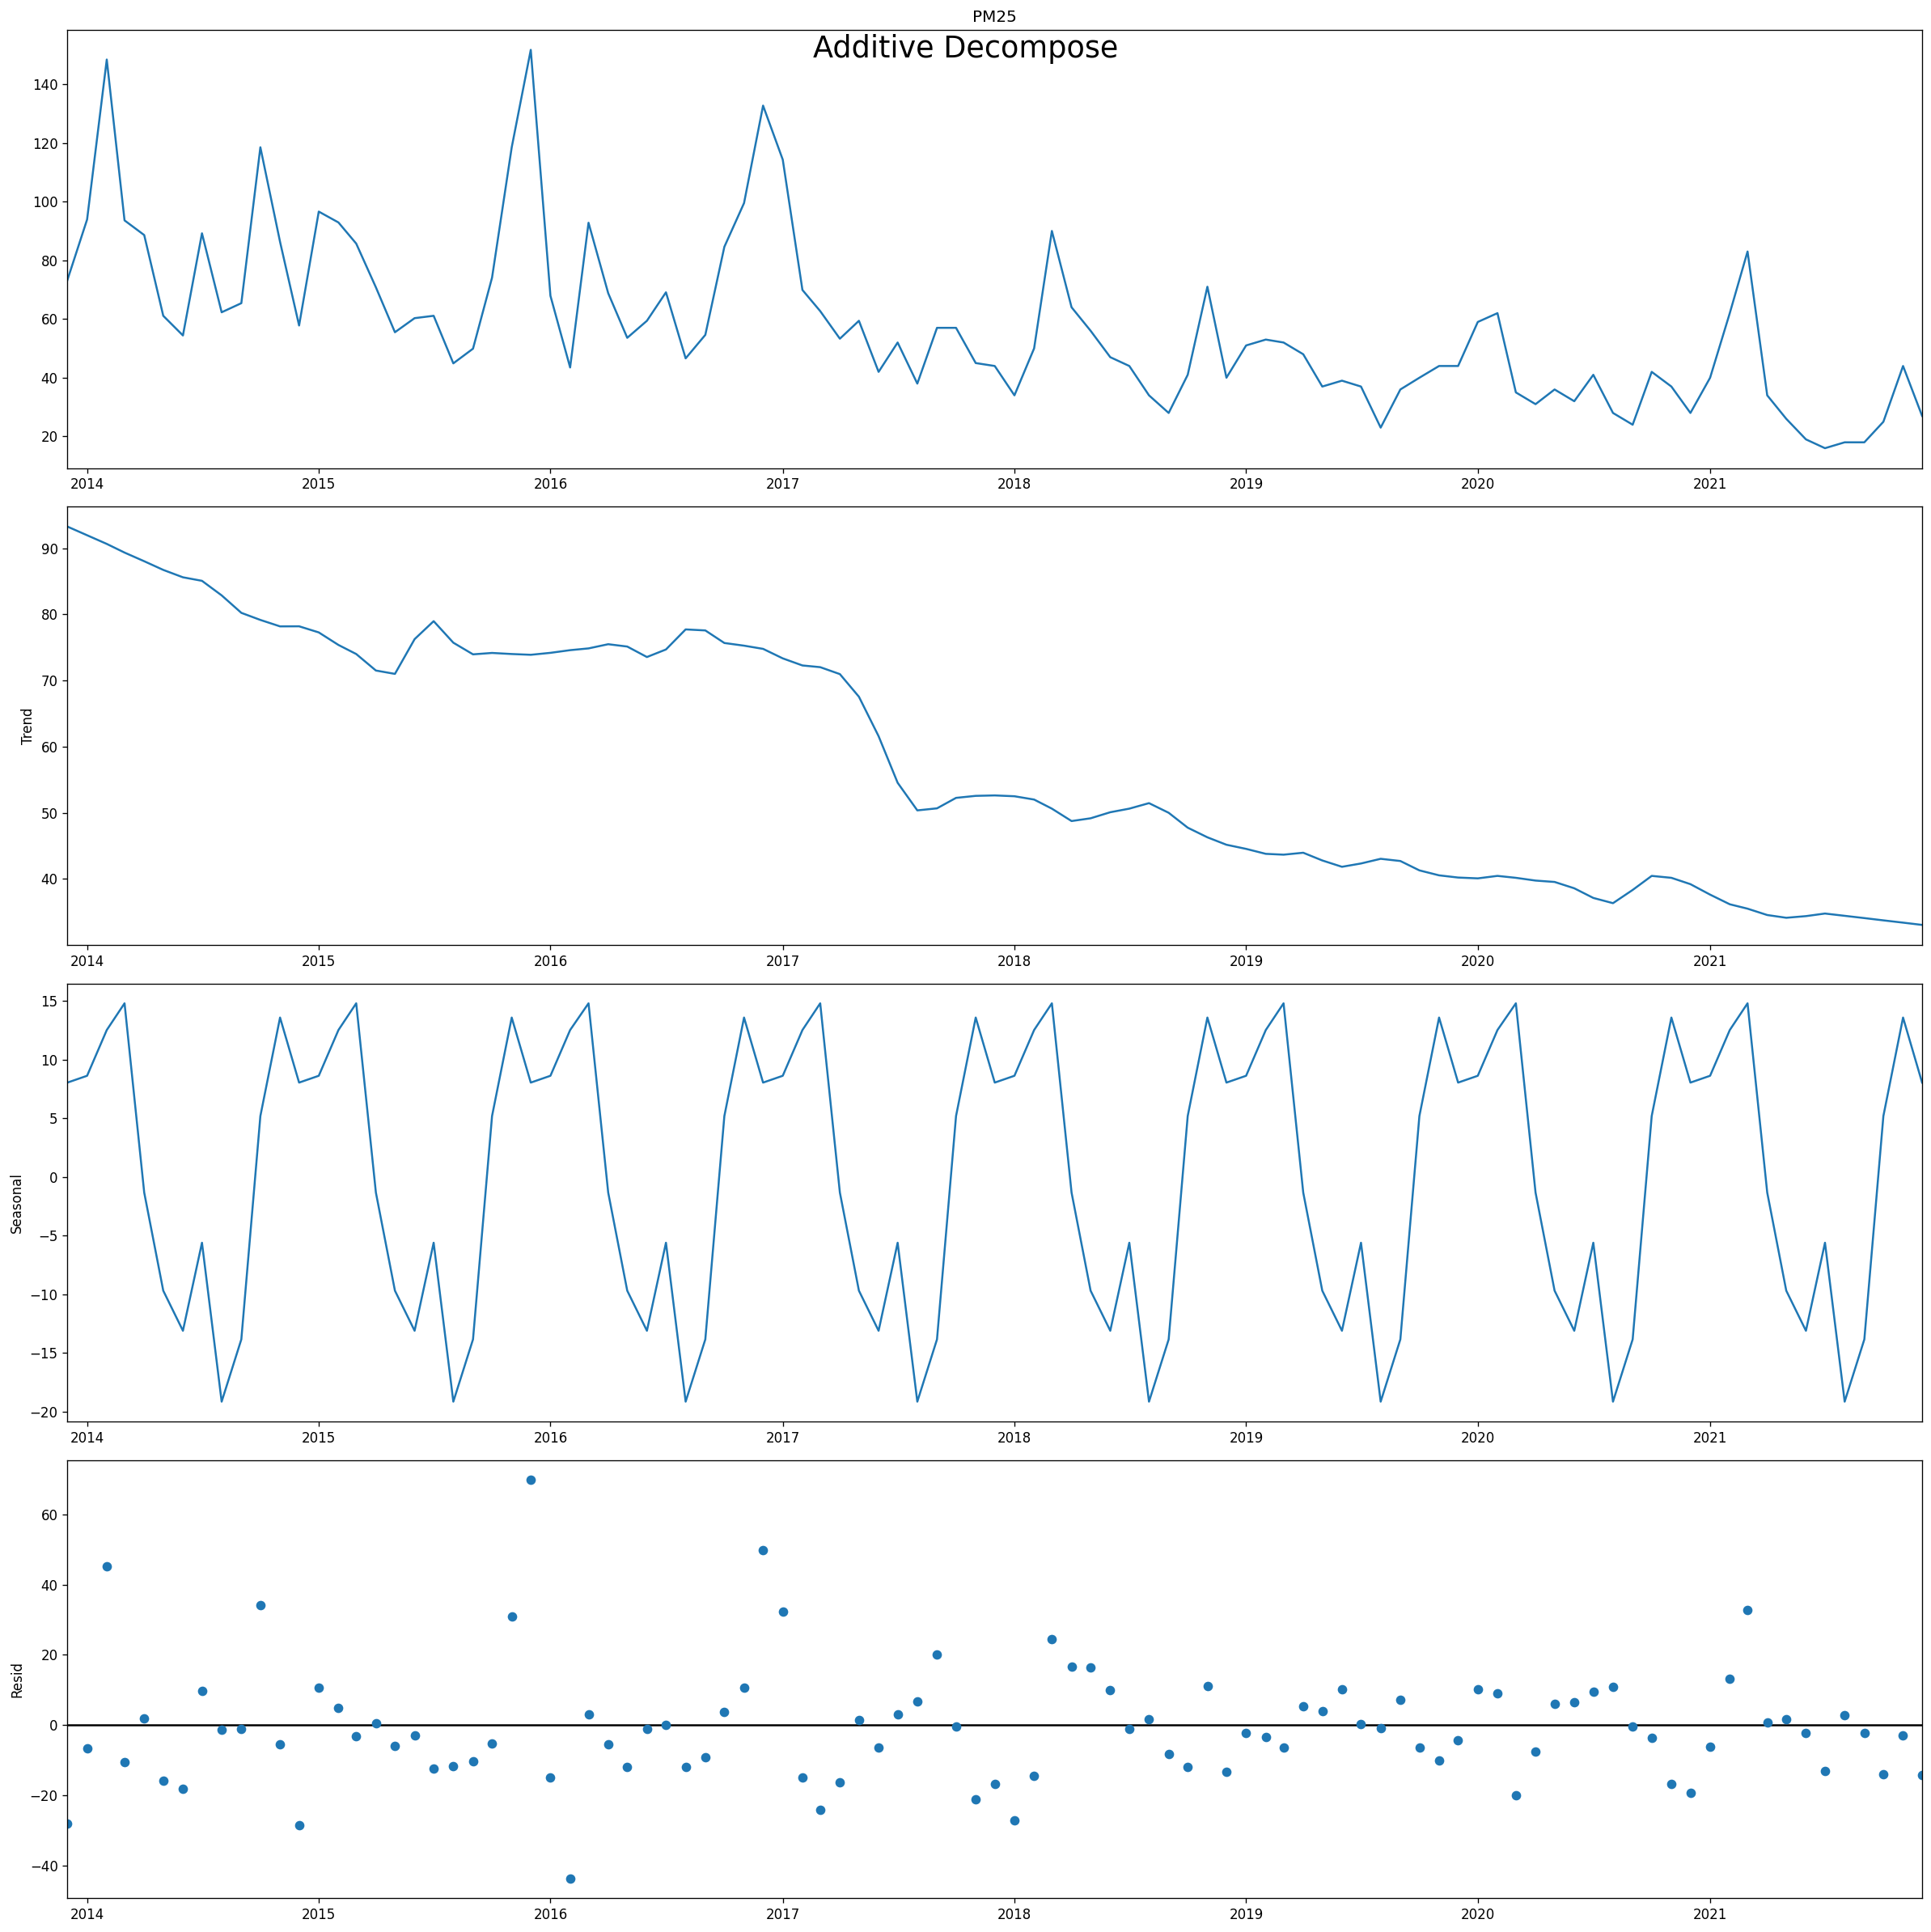

In [ ]:
#prepare data
df['year']=[d.year for d in df.index]
df['month']=[d.strftime('%b') for d in df.index]
years = df['year'].unique()

#prepare colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()),len(years),replace=False)

#draw plot
plt.figure(figsize=(16,12),dpi=80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month','PM25',data=df.loc[df.year==y, :],color=mycolors[i],label = y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9,df.loc[df.year==y,'PM25'][-1:].values[0],y,fontsize=12,color=mycolors[i])

#decorate
plt.gca().set(xlim=(-0.3,11),ylim=(10,180),ylabel='$Concentration$',xlabel='$Month$')
plt.yticks(fontsize=12,alpha=.7)
plt.title("",fontsize=20)
plt.show()

#box plot
fig, axes = plt.subplots(1,2,figsize = (20,7),dpi=80)
sns.boxplot(x='year',y='PM25',data=df,ax=axes[0])
sns.boxplot(x='month',y='PM25',data=df.loc[~df.year.isin([2014,2021]),:])
axes[0].set_title('Year-wise Box Plot\n(The Trend)',fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)',fontsize=18)
plt.show()


#Multiplicative Decomposition
result_mul = seasonal_decompose(df['PM25'], model='multiplicative', extrapolate_trend='freq')

#Additive Decomposition
result_add = seasonal_decompose(df['PM25'], model='additive', extrapolate_trend='freq')

#decomposition plot
plt.rcParams.update({'figure.figsize':(20,20)})
result_mul.plot().suptitle('Multiplicative Decompose',fontsize=22)
result_add.plot().suptitle('Additive Decompose',fontsize=22)
plt.show()



# **De-seasonalize**

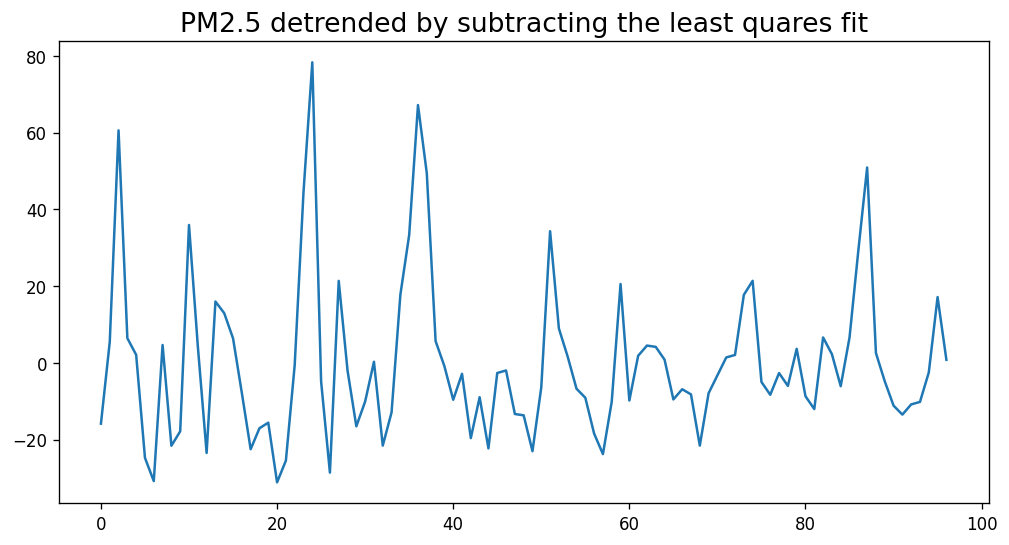

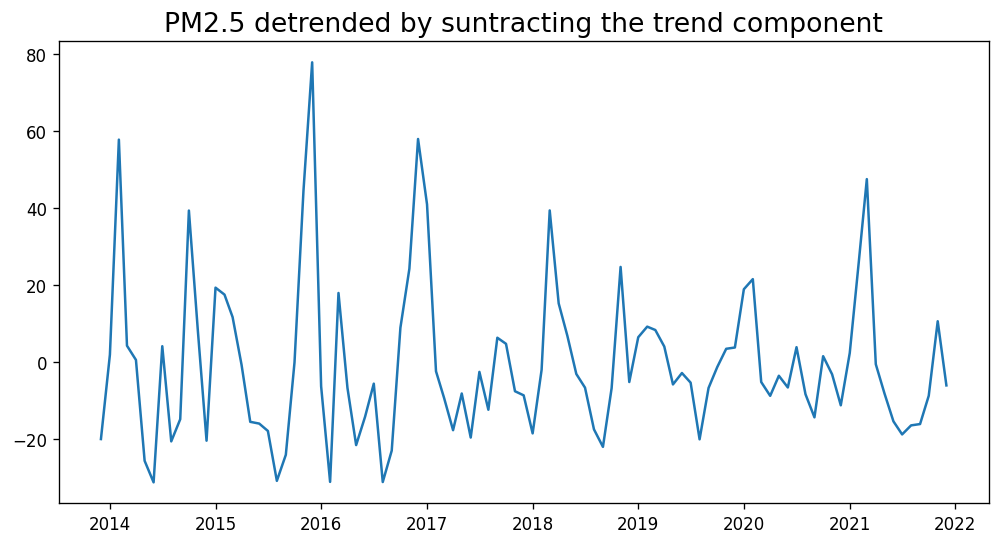

[]

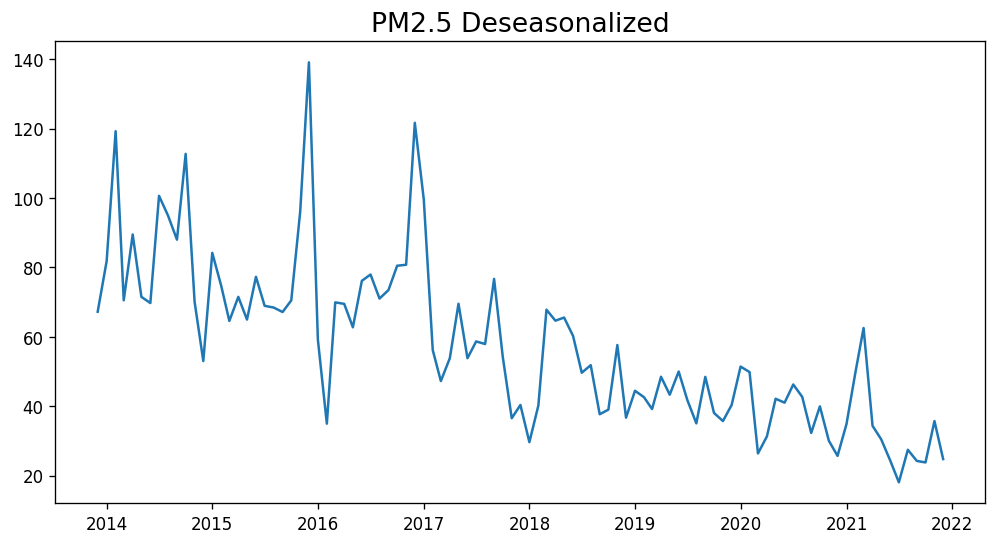

In [ ]:
#de-trend
plt.rcParams.update({'figure.figsize':(10,5)})
detrended = signal.detrend(df.PM25.values)
plt.plot(detrended)
plt.title('PM2.5 detrended by subtracting the least quares fit',fontsize=16)
plt.show()

#using statmodels: subtracting the trend component
detrended_seasonal = df.PM25.values-result_mul.trend
plt.plot(detrended_seasonal)
plt.title('PM2.5 detrended by suntracting the trend component',fontsize = 16)
plt.show()

#de-seasonal
deseasonalized = df.PM25.values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('PM2.5 Deseasonalized',fontsize=16)
plt.plot()

**Plot the ACF and PACF for de-seasonal data**

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


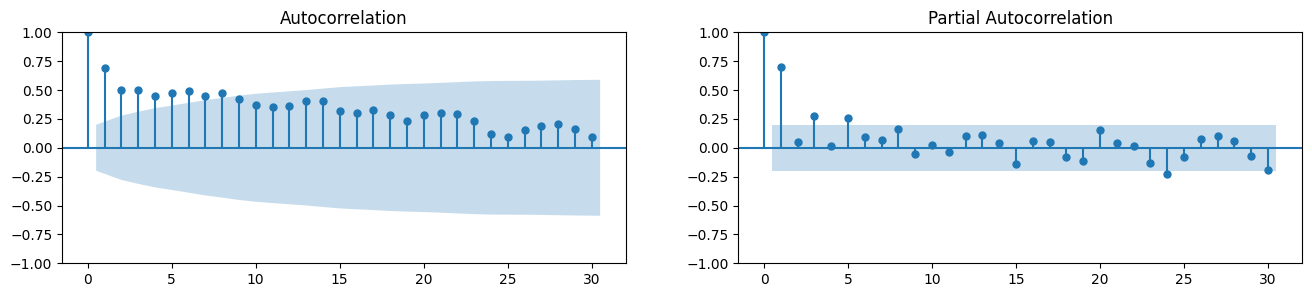

In [ ]:
#pacf
fig,axes = plt.subplots(1,2,figsize =(16,3),dpi=100)
plot_acf(deseasonalized.dropna(),lags=30,ax=axes[0])
plot_pacf(deseasonalized.dropna(),lags=30,ax=axes[1])
plt.show()

# **Apply ARIMA to the de-seasonal data**

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dat

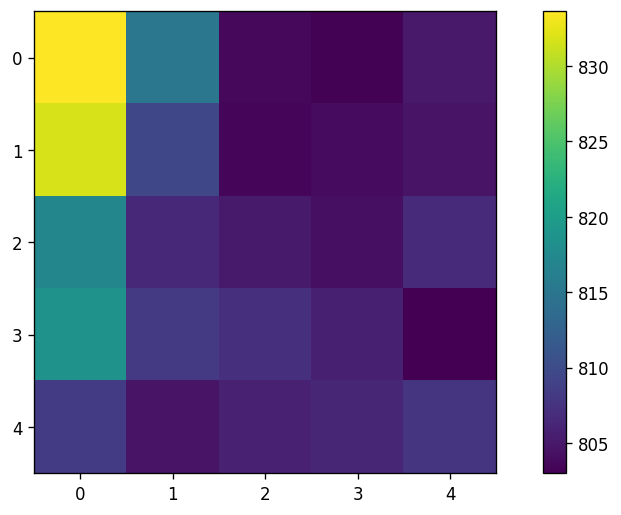

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               seasonal   No. Observations:                   97
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -393.505
Date:                Sun, 16 Apr 2023   AIC                            803.011
Time:                        21:39:44   BIC                            823.525
Sample:                    12-01-2013   HQIC                           811.303
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3459      0.132     -2.614      0.009      -0.605      -0.087
ar.L2          0.9638      0.047     20.701      0.000       0.873       1.055
ar.L3          0.3795      0.155      2.449      0.0

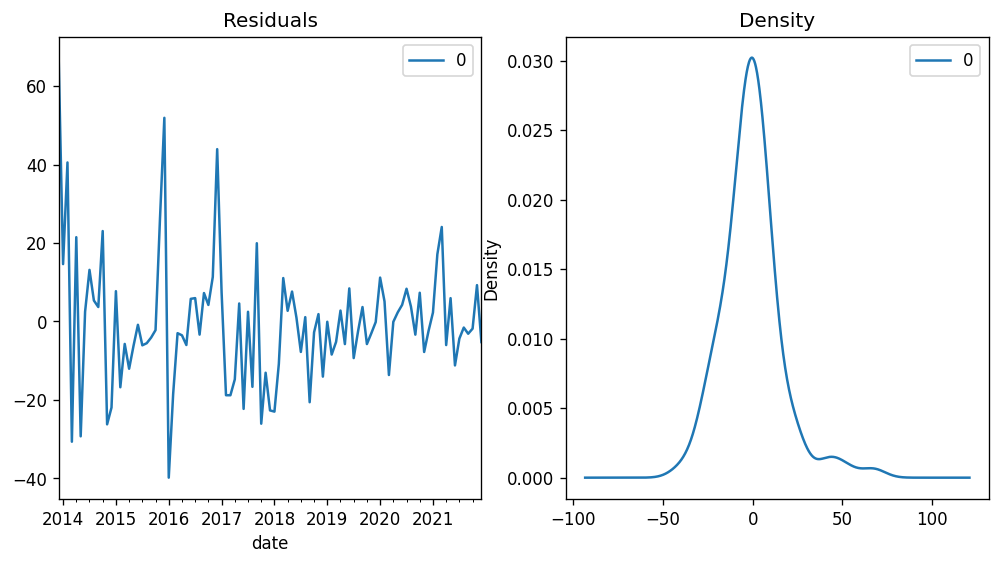

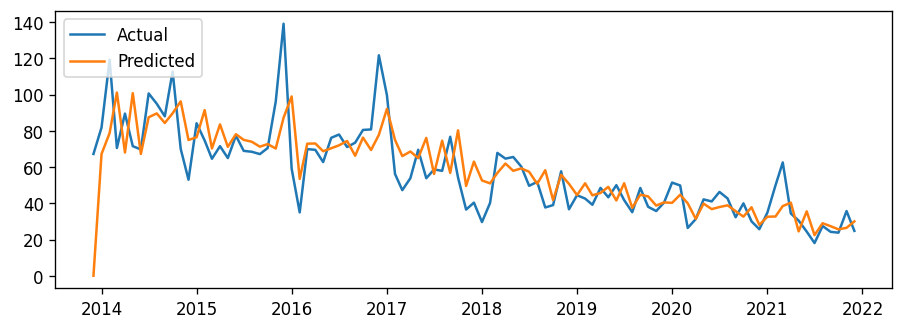

In [ ]:
# run loop over deseasonal 1st diff different lag lengths
results_aic = np.zeros((5,5))
for ar_lag in range(0,5):
    for ma_lag in range(0,5):
        model = ARIMA(deseasonalized, order=(ar_lag,1,ma_lag))
        model_fit = model.fit()
        results_aic[ar_lag,ma_lag] = model_fit.aic
 
# determine optimum lag lengths for deseasonal diff
plt.imshow(results_aic)
plt.colorbar()
plt.show()
np.min(results_aic)
b = np.where(results_aic == np.min(results_aic))


#ARIMA
model = ARIMA(deseasonalized,order=(b[0][0],1,b[1][0]))
model_fit = model.fit()
print(model_fit.summary())

#residual error
plt.rcParams.update({'figure.figsize':(10,5),'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title = 'Density',ax=ax[1])
plt.show()

#Actual VS Fitted
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})
df['predict'] = model_fit.predict()  
plt.plot(deseasonalized,label='Actual')
plt.plot(df.predict, label='Predicted')
plt.legend(loc='upper left')
plt.show()






2021-12-01    30.006464
2022-01-01    21.754017
2022-02-01    25.486323
2022-03-01    24.133805
2022-04-01    22.771816
2022-05-01    23.355857
2022-06-01    21.327792
2022-07-01    22.075394
2022-08-01    20.083721
2022-09-01    20.723593
2022-10-01    18.866337
2022-11-01    19.369687
2022-12-01    17.648329
2023-01-01    18.024096
2023-02-01    16.426043
Freq: MS, Name: predicted_mean, dtype: float64


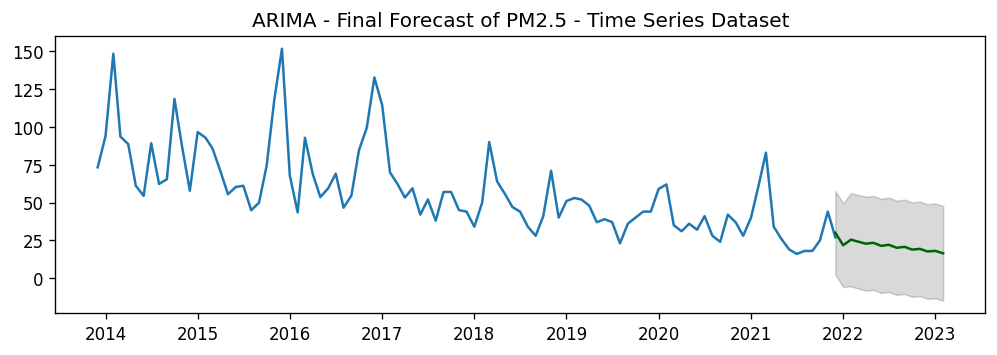

            dates_value
dates                  
2022-01-01           45
2022-02-01           22
2022-03-01           40
2022-04-01           35
2022-05-01           21
2022-06-01           23
2022-07-01           19
2022-08-01           19
2022-09-01           28
2022-10-01           40
2022-11-01           45
2022-12-01           17
2023-01-01           32
2023-02-01           54


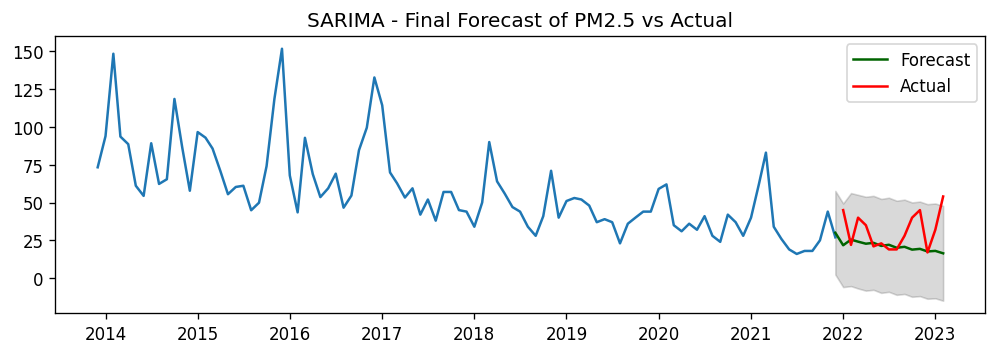

RSME:  16.337539945836298


In [ ]:
#Forecast
n_periods = 15
forecast = model_fit.get_prediction(end=model_fit.nobs + n_periods - 1, alpha=0.05)
fitted_series0 = forecast.predicted_mean
confint = forecast.conf_int()
fitted_series0 = pd.Series(fitted_series0, index=index_of_fc)
lower_series0 = pd.Series(confint["lower seasonal"], index=index_of_fc)
upper_series0 = pd.Series(confint["upper seasonal"], index=index_of_fc)

print(fitted_series0)


# Plot
plt.rcParams.update({'figure.figsize':(10,3)})
plt.plot(df.PM25)
plt.plot(fitted_series0, color='darkgreen')
plt.fill_between(lower_series0.index, 
                 lower_series0, 
                 upper_series0, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of PM2.5 - Time Series Dataset")
plt.show()

#import the actual data
dates = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01','2023-01-01','2023-02-01']
dates_value = [45,22,40,35,21,23,19,19,28,40,45,17,32,54]
data_future = list(zip(dates,dates_value))
df1 = pd.DataFrame(data_future,columns = ['dates','dates_value'])
df1['dates'] = pd.to_datetime(df1['dates'])
df1.set_index('dates',inplace = True)
print(df1)

plt.rcParams.update({'figure.figsize':(10,3)})
dates, dates_value = zip(*data_future)
plt.plot(df.PM25)
plt.plot(fitted_series0, label='Forecast', color='darkgreen')

plt.fill_between(lower_series0.index, 
                 lower_series0, 
                 upper_series0, 
                 color='k', alpha=.15)
plt.plot(df1.index,df1.dates_value, label='Actual',color='red')
plt.title("SARIMA - Final Forecast of PM2.5 vs Actual")
plt.legend()
plt.show()

#RSME
error = fitted_series0-df1.dates_value 
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)
print("RSME: ", rmse)




# **Apply SARIMA**

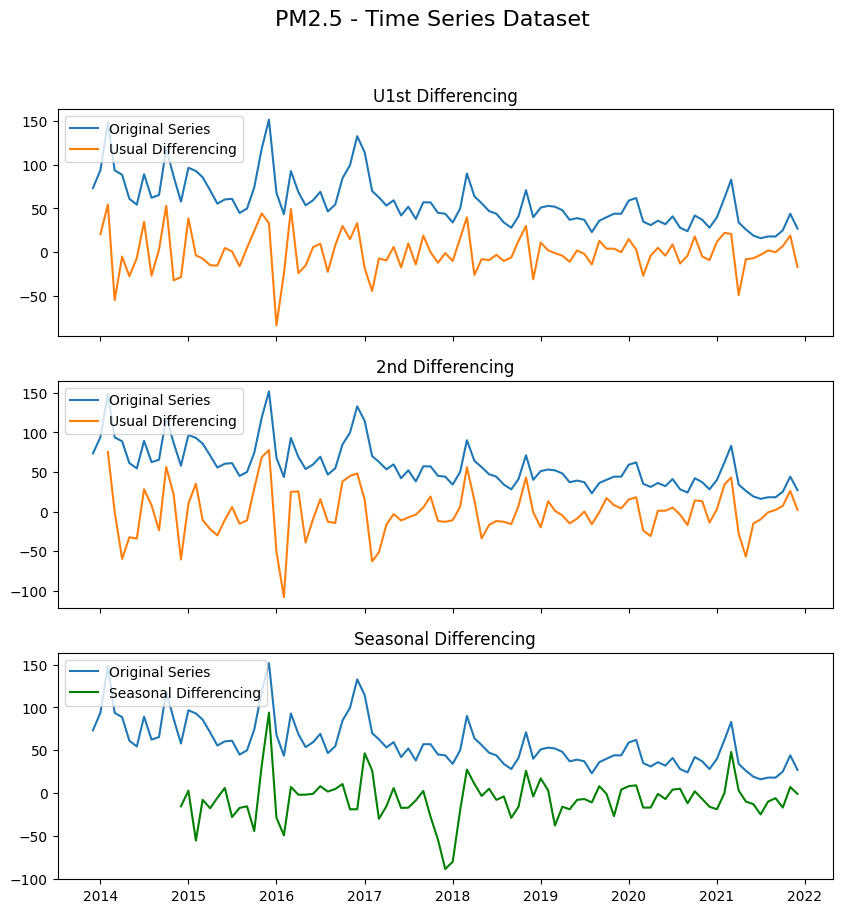

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=808.745, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=799.909, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=808.515, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=791.663, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=792.645, Time=0.36 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=771.740, Time=1.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=782.543, Time=0.52 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=773.440, Time=0.73 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=2.50

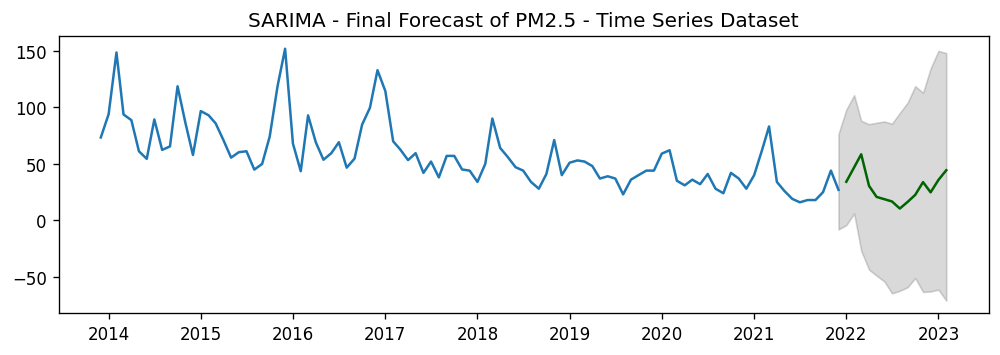

In [ ]:
#SARIMA
data = pd.read_csv('airpollution.csv',parse_dates=['date'], index_col='date')
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,10), dpi=100, sharex=True)
# 1st Differencing
axes[0].plot(data.PM25, label='Original Series')
axes[0].plot(data.PM25.diff(1), label='Usual Differencing')
axes[0].set_title('U1st Differencing')
axes[0].legend(loc='upper left', fontsize=10)
# 2nd Differencing
axes[1].plot(data.PM25, label='Original Series')
axes[1].plot(data.PM25.diff(2), label='Usual Differencing')
axes[1].set_title('2nd Differencing')
axes[1].legend(loc='upper left', fontsize=10)
# Seasonal Differencing
axes[2].plot(data.PM25, label='Original Series')
axes[2].plot(data.PM25.diff(12), label='Seasonal Differencing', color='green')
axes[2].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('PM2.5 - Time Series Dataset', fontsize=16)
plt.show()

#seasonal-fit stepwise auto-ARIMA
smodel = pm.auto_arima(df.PM25, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(smodel.summary())
smodel_fitted = smodel.fit(df['PM25'])

#Forecast
n_periods = 15
fitted, confint = smodel.predict(n_periods = n_periods, return_conf_int = True)
index_of_fc = pd.date_range(df.index[-1],periods = n_periods, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

print(fitted_series)


# Plot
plt.rcParams.update({'figure.figsize':(10,3)})
plt.plot(df.PM25)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of PM2.5 - Time Series Dataset")
plt.show()




In [ ]:
print(smodel_fitted.predict())

2022-01-01    34.135995
2022-02-01    46.850258
2022-03-01    58.423380
2022-04-01    30.547003
2022-05-01    20.759242
2022-06-01    18.718290
2022-07-01    16.726176
2022-08-01    10.483170
2022-09-01    16.378323
2022-10-01    22.543783
Freq: MS, dtype: float64


**Plot the actual PM2.5 and tha PM2.5 we forecast**

            dates_value
dates                  
2022-01-01           45
2022-02-01           22
2022-03-01           40
2022-04-01           35
2022-05-01           21
2022-06-01           23
2022-07-01           19
2022-08-01           19
2022-09-01           28
2022-10-01           40
2022-11-01           45
2022-12-01           17
2023-01-01           32
2023-02-01           54


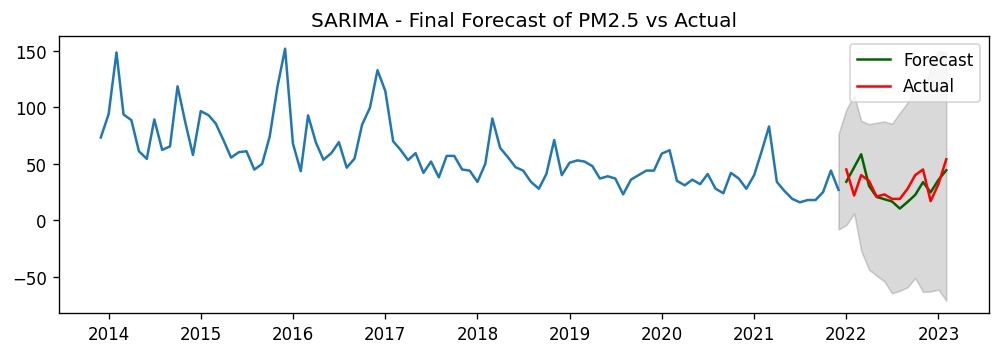

RSME:  11.7237044392129


In [ ]:
#import the actual data
dates = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01','2023-01-01','2023-02-01']
dates_value = [45,22,40,35,21,23,19,19,28,40,45,17,32,54]
data_future = list(zip(dates,dates_value))
df1 = pd.DataFrame(data_future,columns = ['dates','dates_value'])
df1['dates'] = pd.to_datetime(df1['dates'])
df1.set_index('dates',inplace = True)
print(df1)

#plot the forecast and the actual value
plt.rcParams.update({'figure.figsize':(10,3)})
dates, dates_value = zip(*data_future)
plt.plot(df.PM25)
plt.plot(fitted_series, label='Forecast', color='darkgreen')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(df1.index,df1.dates_value, label='Actual',color='red')
plt.title("SARIMA - Final Forecast of PM2.5 vs Actual")
plt.legend()
plt.show()

#RSME
error = fitted_series-df1.dates_value 
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)
print("RSME: ", rmse)



# **Apply SARIMAX**

In [ ]:
#SARIMAX
sxmodel = sm.tsa.statespace.SARIMAX(df.PM25, order=(2, 1, 0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sxmodel.fit()
print(results.summary())

#residual error
plt.rcParams.update({'figure.figsize':(12,5),'figure.dpi':120})
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title = 'Density',ax=ax[1])
plt.show()


#Forecast
n_periods = 15
forecast = results.get_prediction(end=results.nobs + n_periods - 1, alpha=0.05)
forecast_series = forecast.predicted_mean
confint1 = forecast.conf_int()
forecast_series = pd.Series(forecast_series, index=index_of_fc)
lower_series1 = pd.Series(confint1["lower PM25"], index=index_of_fc)
upper_series1 = pd.Series(confint1["upper PM25"], index=index_of_fc)

print(forecast)

# Plot
plt.rcParams.update({'figure.figsize':(10,3)})
plt.plot(df.PM25)
plt.plot(forecast_series, color='darkgreen')
plt.fill_between(lower_series1.index, 
                 lower_series1, 
                 upper_series1, 
                 color='k', alpha=.15)

plt.title("SARIMAX - Final Forecast of PM2.5 - Time Series Dataset")
plt.show()



NameError: ignored

**Plot the actual PM2.5 and PM2.5 we forecast**

In [ ]:
#plot the forecast and the actual value
plt.rcParams.update({'figure.figsize':(10,3)})
dates, dates_value = zip(*data_future)
plt.plot(df.PM25)
plt.plot(forecast_series, label='Forecast',color='darkgreen')

plt.fill_between(lower_series1.index, 
                 lower_series1, 
                 upper_series1, 
                 color='k', alpha=.15)
plt.plot(df1.index,df1.dates_value, label='Actual', color='red')
plt.title("SARIMAX - Final Forecast of PM2.5 vs Actual")
plt.legend()
plt.show()

#RSME
error = forecast_series-df1.dates_value 
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)
print("RSME: ", rmse)


In [ ]:
print(forecast_series)

# **Apply LSTM**

In [ ]:
#LSTM
dataset = df.drop(['CityName','AQI','PM10','SO2','CO','NO','O3','temp'],axis=1)
training_data_len = math.ceil(len(dataset)*0.8)
print(training_data_len)

78


In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 15
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(63, 15, 1)

**prediction**

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")
model.fit(x_train,y_train, batch_size=1, epochs=1)

#prediction
test_data = scaled_data[training_data_len-15: , :]
x_test = []
y_test = scaled_data[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

pre = model.predict(dataset)
mse = np.mean((pre - dataset)**2)
print('mse=',mse)

4/4 [==============================] - 1s 4ms/step
mse= PM25    4068.587775
dtype: float64


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid["Predictions"] = predictions
valid

<ipython-input-76-fa1e26d85be2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


,CityName,AQI,PM25,PM10,SO2,CO,NO,O3,temp,Predictions
date,,,,,,,,,,
2020-06-01,北京市,116,32.0,67.0,3.0,0.57,23.0,174.0,24.7,45.339443
2020-07-01,北京市,99,41.0,47.0,3.0,0.67,21.0,150.0,27.0,44.845089
2020-08-01,北京市,80,28.0,41.0,3.0,0.65,22.0,131.0,25.6,44.558807
2020-09-01,北京市,56,24.0,35.0,3.0,0.54,26.0,96.0,19.7,44.158970
2020-10-01,北京市,72,42.0,70.0,3.0,0.56,41.0,60.0,12.3,43.519924
2020-11-01,北京市,66,37.0,62.0,3.0,0.65,42.0,41.0,2.4,43.257061
2020-12-01,北京市,56,28.0,56.0,5.0,0.62,38.0,40.0,-5.0,43.220963
2021-01-01,北京市,72,40.0,75.0,4.0,0.70,31.0,49.0,-7.9,42.872292
2021-02-01,北京市,93,62.0,81.0,4.0,0.80,28.0,72.0,-3.5,42.710052


**Plot the prediction and Actual data**

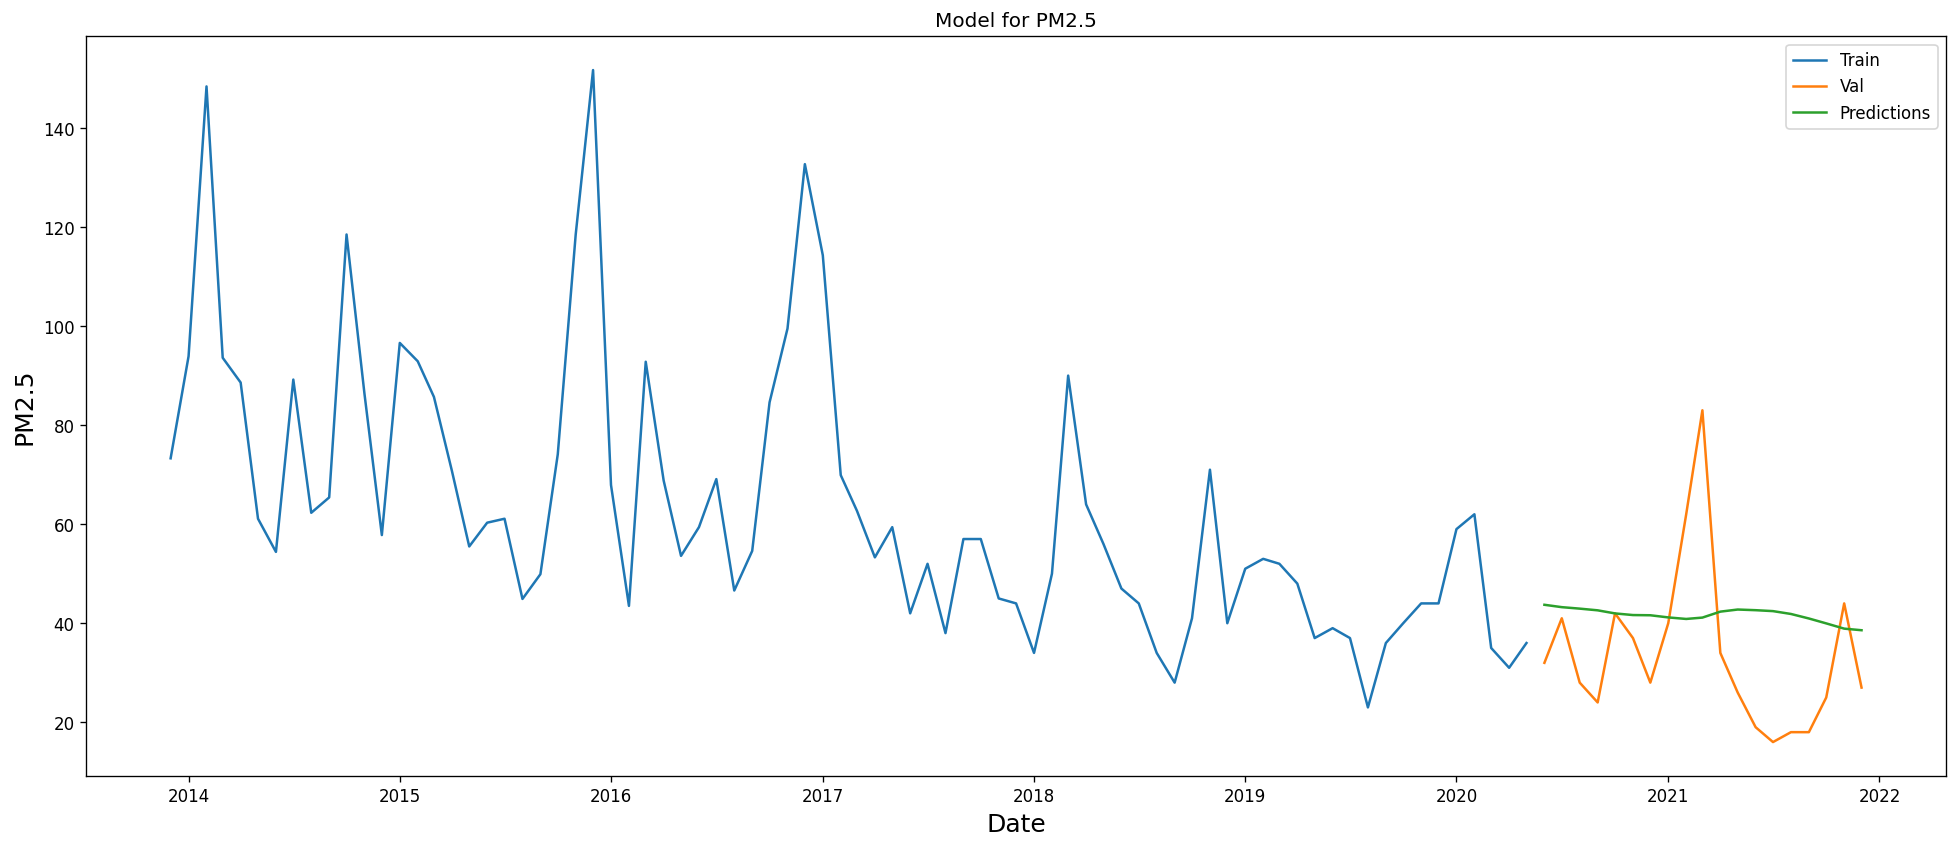

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[dataset.columns])
plt.plot(valid['PM25'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])

# **VAR**

In [ ]:
!pip install arch
#high level utilities
import pandas as pd
import numpy as np
from dateutil.parser import parse
from google.colab import files

#graphing tools
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

#statistics tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch import arch_model


uploaded = files.upload()
df = pd.read_csv('IND.csv',parse_dates=['date'])
df.index = df['date']
df.drop(columns=['date'],inplace=True)
print(df.head())
print(df.columns)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving IND.csv to IND (3).csv
               revenue   PM25
date                         
2013-12-01  1862482000   73.3
2014-02-01   273681000  148.4
2014-03-01   432621000   93.6
2014-04-01   587409000   88.6
2014-05-01   738852000   61.1
Index(['revenue', 'PM25'], dtype='object')


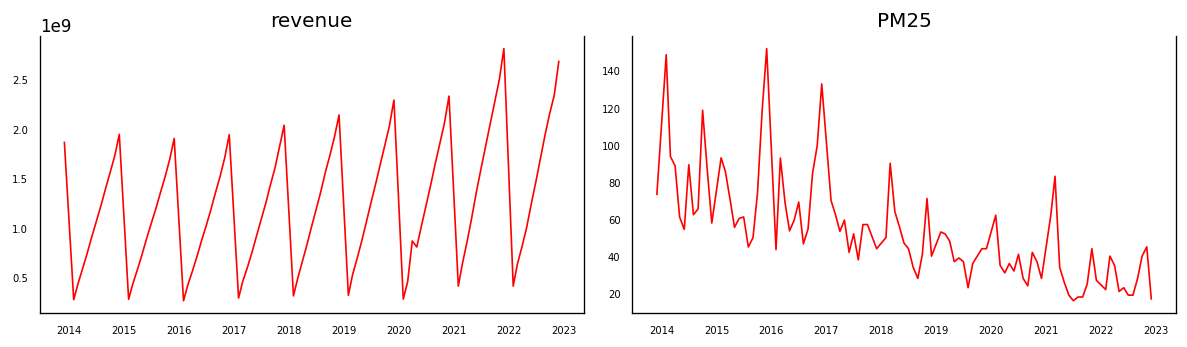

In [ ]:
def plot_two_chart(data):

    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,3))
    for i, ax in enumerate(axes.flatten()):
        data1 = data[data.columns[i]]
        ax.plot(data1, color='red', linewidth=1)
        # Decorations
        ax.set_title(data.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout()
    plt.show()

plot_two_chart(df)


In [ ]:
df_diff = df.copy()
for i in df_diff.columns[:2]:
    df_diff[i] = df_diff[i].diff().dropna()

nobs = 4 #number of observations to forecast
df_diff_train, df_diff_test = df_diff[1:-nobs], df_diff[-nobs:]
print("\n --------------------Differenced data-------------------- \n")
print(df_diff)


 --------------------Differenced data-------------------- 

                 revenue  PM25
date                          
2013-12-01           NaN   NaN
2014-02-01 -1.588801e+09  75.1
2014-03-01  1.589400e+08 -54.8
2014-04-01  1.547880e+08  -5.0
2014-05-01  1.514430e+08 -27.5
...                  ...   ...
2022-08-01  2.400000e+08   0.0
2022-09-01  2.400000e+08   9.0
2022-10-01  2.100000e+08  12.0
2022-11-01  1.900000e+08   5.0
2022-12-01  3.400000e+08 -28.0

[99 rows x 2 columns]


In [ ]:
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df10 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df10.columns:
        for r in df10.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df10.loc[r, c] = min_p_value
    df10.columns = [var + '_x' for var in variables]
    df10.index = [var + '_y' for var in variables]
    return df10

gc_out = grangers_causation_matrix(df, variables = df.columns)
print("\n --------------------Granger causality test results-------------------- \n")
print(gc_out) #test that column var causes row var, null is that column var doesn't cause row variable



 --------------------Granger causality test results-------------------- 

           revenue_x  PM25_x
revenue_y     1.0000     0.0
PM25_y        0.0362     1.0


In [ ]:
def cointegration_test(df, alpha=0.05, lags=3):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,det_order=0,k_ar_diff=lags)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    print(traces)
    print(cvts)
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

print("\n --------------------Cointegration test results-------------------- \n")
cointegration_test(df, lags=2)



 --------------------Cointegration test results-------------------- 

[54.47685752 11.1339157 ]
[15.4943  3.8415]
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
revenue ::  54.48     > 15.4943   =>   True
PM25   ::  11.13     > 3.8415    =>   True


In [ ]:
print("\n --------------------VAR lag test results-------------------- \n")
model = VAR(df_diff_train)
for i in [1,2,3,4,5,6,7,8,9]:
    try:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        print("Can't fit more lags due to dataset.")
     



 --------------------VAR lag test results-------------------- 

Lag Order = 1
AIC :  46.65896271275901
BIC :  46.82235622844632
FPE :  1.8354792830743177e+20
HQIC:  46.72493634043129 

Lag Order = 2
AIC :  46.60047778722296
BIC :  46.874585241250024
FPE :  1.7315039094396106e+20
HQIC:  46.711109878192815 

Lag Order = 3
AIC :  46.52045449477909
BIC :  46.906740572704756
FPE :  1.598973221784927e+20
HQIC:  46.67629686810172 

Lag Order = 4
AIC :  46.43279123057078
BIC :  46.932753164636836
FPE :  1.4658433782145027e+20
HQIC:  46.63440527073063 

Lag Order = 5
AIC :  46.504086928935365
BIC :  47.11925546976803
FPE :  1.576056380428776e+20
HQIC:  46.7520437140855 



/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 6
AIC :  46.41993298578543
BIC :  47.151873408244896
FPE :  1.4514845229162198e+20
HQIC:  46.7148134090555 

Lag Order = 7
AIC :  46.24956509548492
BIC :  47.099878239848564
FPE :  1.227305912047595e+20
HQIC:  46.59195997802642 

Lag Order = 8
AIC :  46.26711696937577
BIC :  47.23744031905739
FPE :  1.253528534653808e+20
HQIC:  46.65762716364278 

Lag Order = 9
AIC :  46.157812256205034
BIC :  47.24982105322424
FPE :  1.1291499166845614e+20
HQIC:  46.597048737776376 




 --------------------VAR MODEL-------------------- 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Apr, 2023
Time:                     22:40:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    46.9067
Nobs:                     91.0000    HQIC:                   46.6763
Log likelihood:          -2360.93    FPE:                1.59897e+20
AIC:                      46.5205    Det(Omega_mle):     1.37871e+20
--------------------------------------------------------------------
Results for equation revenue
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const         624157.933132  58972492.325880            0.011           0.992
L1.revenue        -0.185290         0.102723           -1.804           0.071
L1.PM25     -118

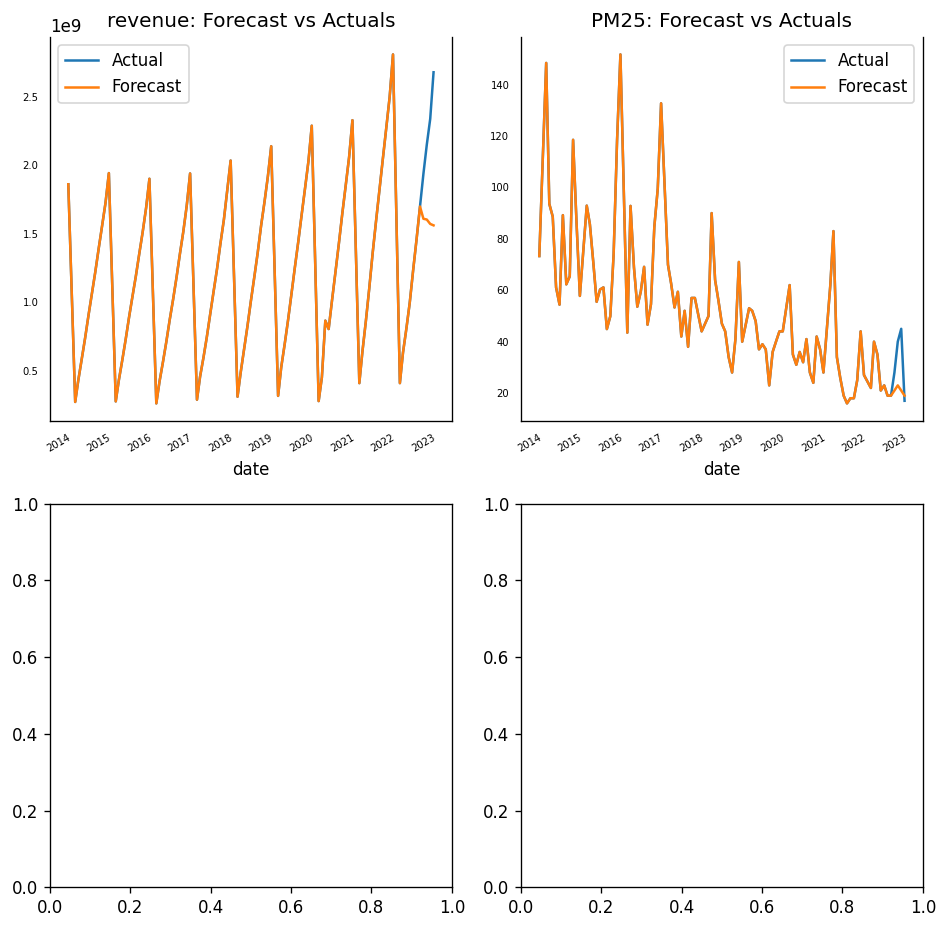

In [ ]:
##Train VAR model
print("\n --------------------VAR MODEL-------------------- \n")
model_fitted = model.fit(3)
print(model_fitted.summary())

##Forecasting
lag_order = model_fitted.k_ar
forecast_input = df_diff_train.values[-lag_order:]
print("\n --------------------Input into forecasts-------------------- \n")
print(forecast_input)

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_diff.index[-nobs:], columns=df_diff.columns)
print("\n --------------------FORECASTS - difference-------------------- \n")
print(df_forecast)

##Un-differencing forecasts
columns = df.columns
for col in columns[:2]:
    x, x_diff = df[col].iloc[-nobs-1], df_forecast[col]
    y = np.r_[x, x_diff].cumsum().astype(int)
    df_forecast[col] = y[1:]
print("\n --------------------FORECASTS - level-------------------- \n")
print(df_forecast)


##put forecasts and data together
df_nonforecast = df[0:-nobs]
df_results = pd.concat([df_nonforecast,df_forecast])


#Plot actuals versus forecast
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(8,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(legend=True, ax=ax, label="Actual")
    df_results[col].plot(legend=True, ax=ax, label="Forecast")
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()


# **Deseasonal of IND**

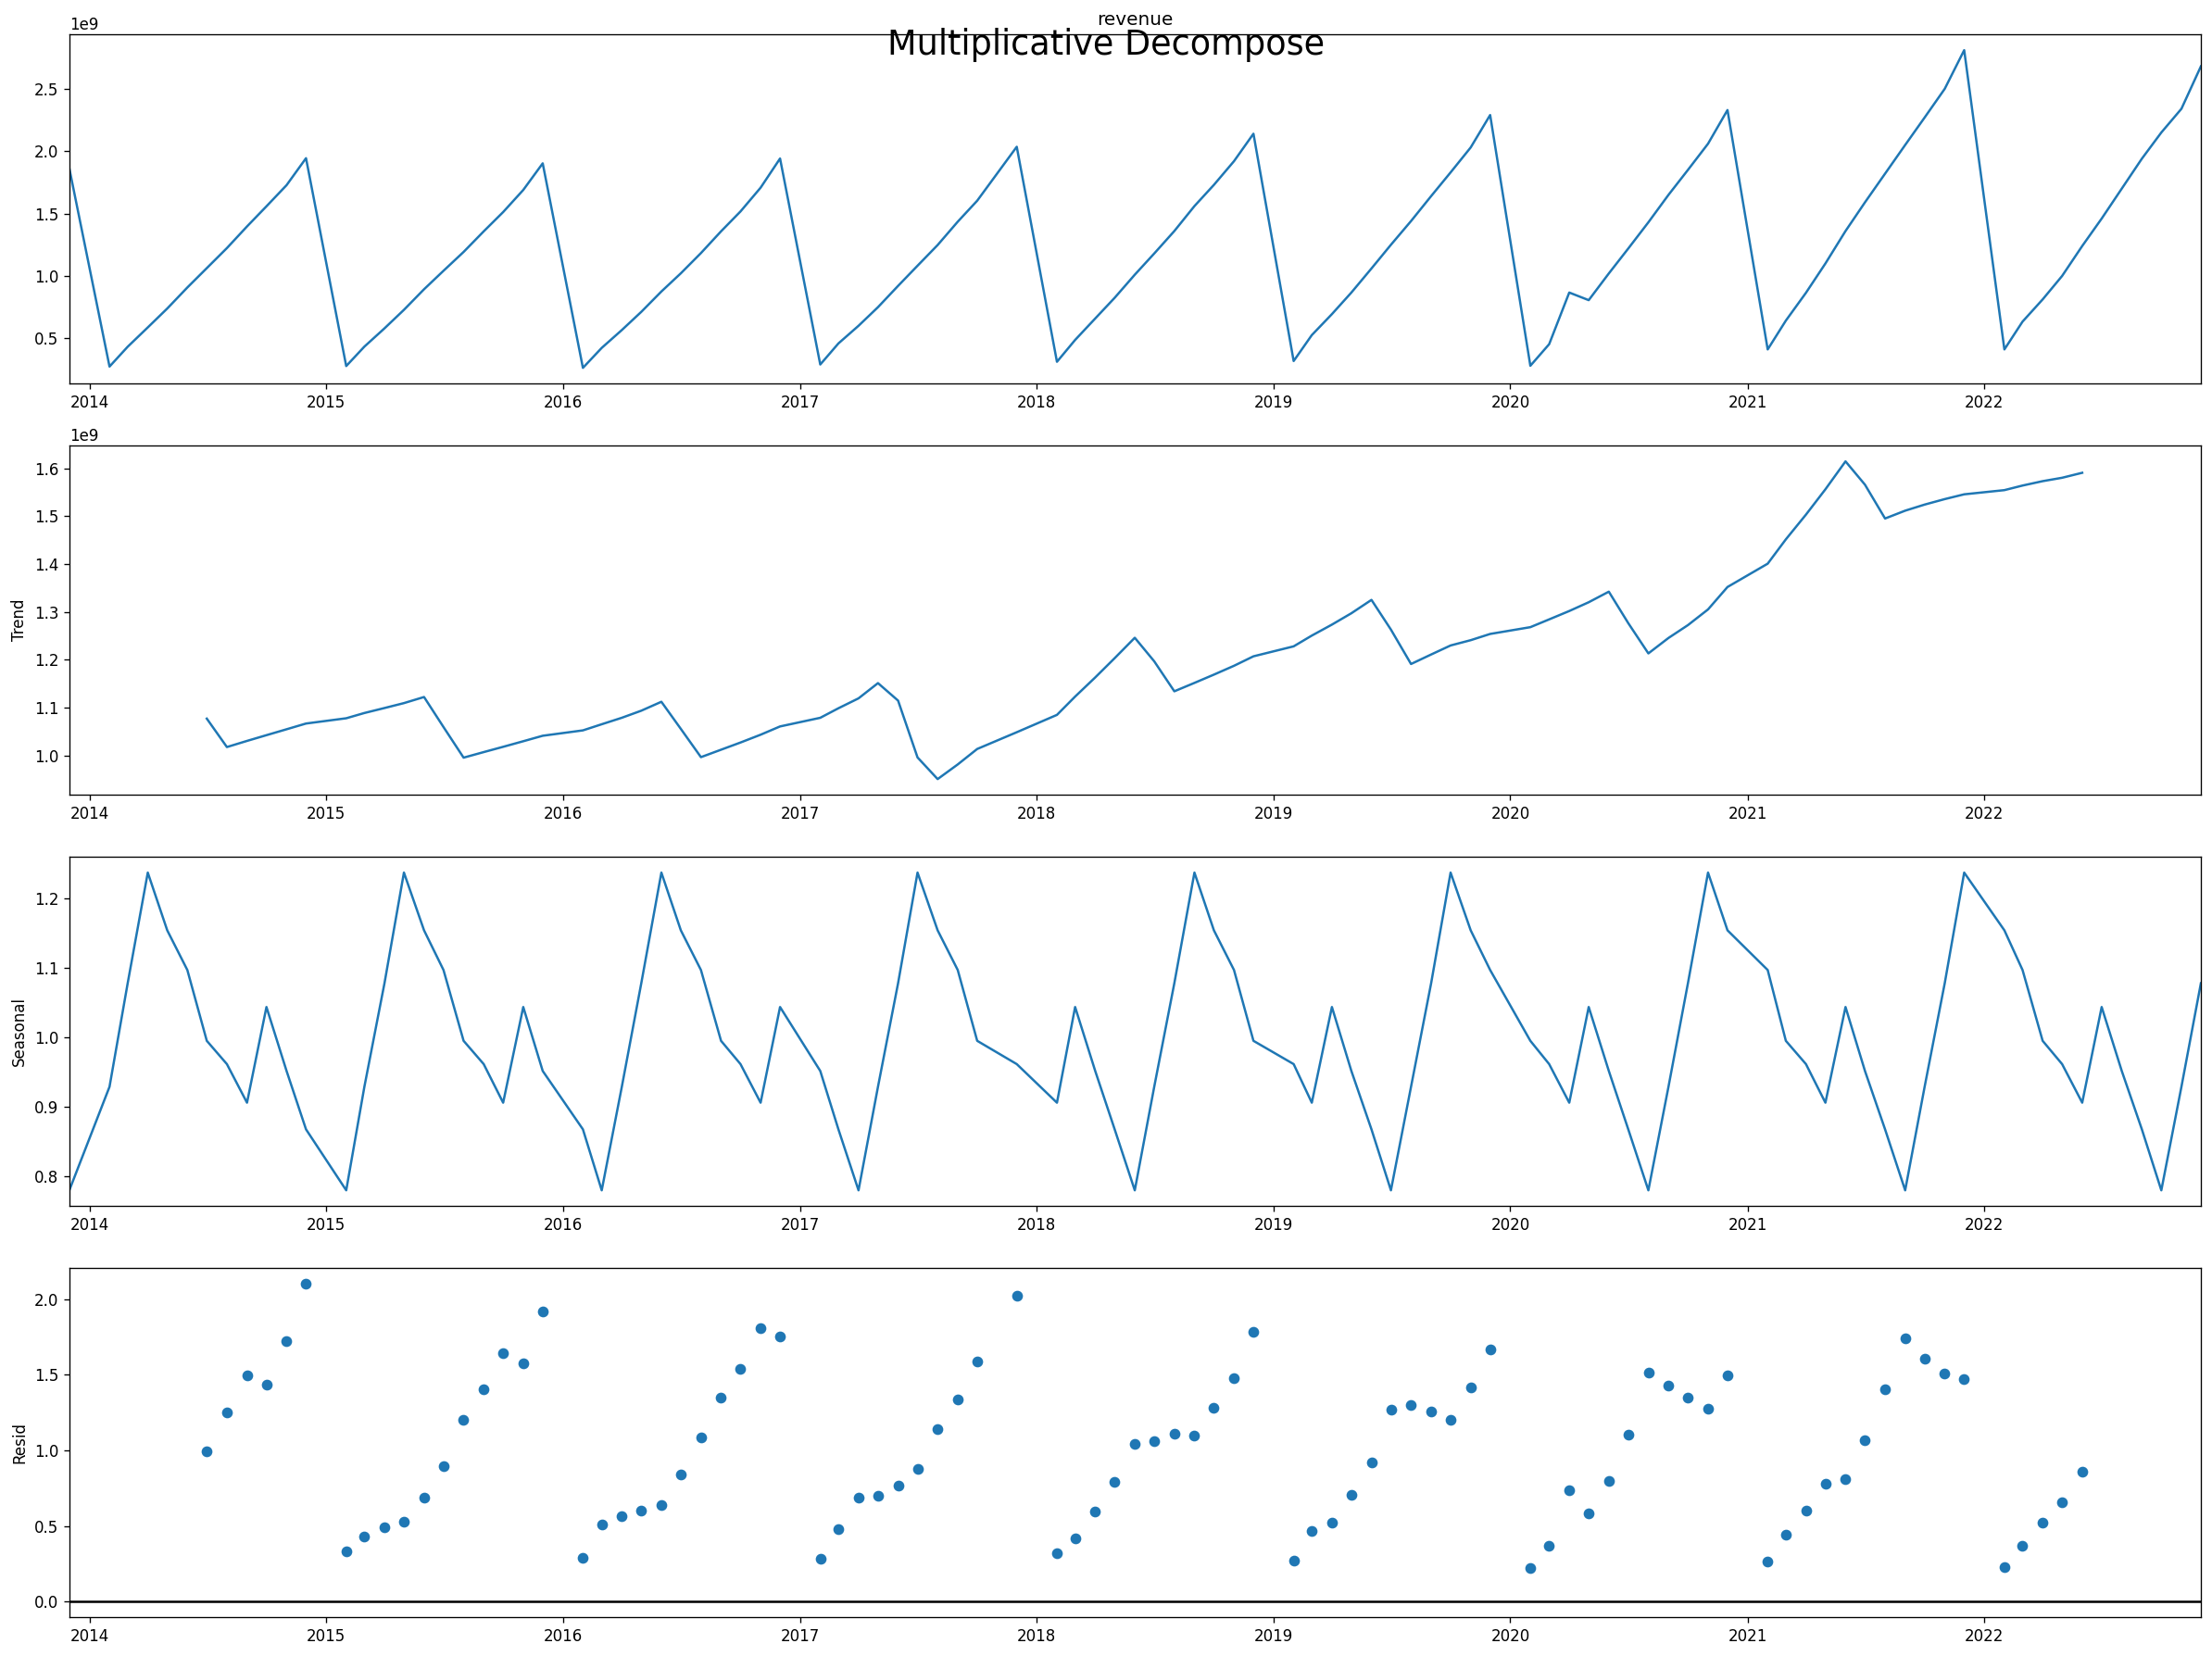

In [ ]:
df['year']=[d.year for d in df.index]
df['month']=[d.strftime('%b') for d in df.index]
years = df['year'].unique()


#Multiplicative Decomposition
result_mul = seasonal_decompose(df['revenue'], model='multiplicative',period=12)
plt.rcParams.update({'figure.figsize':(20,15)})
result_mul.plot().suptitle('Multiplicative Decompose',fontsize=22)
plt.show()